# Lab Session #3
## Computational Neurophysiology [E010620A]
### Dept of Electronics and Informatics (VUB) and Dept of Information Technology (UGent)
Jorne Laton, Matthias Inghels, Talis Vertriest, Jeroen Van Schependom, Sarah Verhulst

<font color=blue>Student names and IDs:</font> Constantijn Coppers (02010771)
<br>
<font color=blue>Academic Year:</font> 2023-2024

<a id="top"></a> 

# Basic Analysis of Spike Train Data

This exercise is adapted from the examples provided in the textbook "Case Studies in Neural Data Analysis", by Mark Kramer and Uri Eden (2016, MIT Press) and the 2020 eLife-LABs publication by Emily Schlafly, Anthea Cheung, Samantha Michalka, Paul Lipton, Caroline Moore-Kochlacs, Jason Bohland, Uri Eden, Mark Kramer. The outline of this exercise follows the theory presented in chapter 7 of "Neuronal Dynamics" by Gerstner, Kistler, Naud, Paninski (2014, Cambridge University Press). It uses two different datasets to introduce and develop some the concepts.

## Aim<a id="introduction"></a>

Typically, the first step in any data analysis involves visualizing and using simple descriptive statistics to characterize pertinent features of the data. For time series data that take on a continuous value at each time point, like the field potentials analyzed in earlier notebooks, we typically start by simply plotting each data value as a function of time. For spike train data, things can become a bit more complicated. One reason for this is that there are multiple equivalent ways to describe the same spike train data. The data could be stored as a sequence of spike times; as a sequence of waiting times between spikes (interspike intervals); or as a discrete time series indicating the number of spikes in discrete time bins. Knowing how to manipulate and visualize spike train data using all these different representations is the first step understanding the structure of the data and is the primary goal of this notebook.

### Case Study 1: Retina Neuron<a id="CS1"></a>

Neurons in the retina typically respond to patterns of light displayed over small sections of the visual field. However, when retinal neurons are grown in culture and held under constant light and environmental conditions, they will still spontaneously fire action potentials. In a fully functioning retina, this spontaneous activity is sometimes described as background firing activity, which is modulated as a function of visual stimuli. It is useful to understand the properties of this background activity in order to determine in future experiments how these firing properties are affected by specific stimuli.

#### Data

A researcher is examining the background firing properties of one of these neurons. He records the spiking activity in one of two states, with the room lights off (low ambient light levels) or with the room lights on (high ambient light levels) and would like to determine whether there is a difference in background firing between these two conditions, and whether one environment is more conducive to future experimental analyses. He records the spiking activity for 30 seconds in each condition.

<div class="question">

**Data:** Spontaneous spiking activity from a retinal neuron in culture, exposed to low-light and high-light environments.

**Goal:** Visualize spike trains, compute and interpret descriptive statistics.

**Tools:** Raster plots, interspike interval histograms, firing rate, autocorrelograms.
    
</div>

#### Before you start
To prepare your environment for this exercise, you'll have to install the nitime package
e.g. type `pip install nitime` in the command line after opening conda or your conda environment

In [1]:
# Prepare the standard modules and load in the data 
from pylab import *
import scipy.io as sio
import warnings
%matplotlib inline
rcParams['figure.figsize'] = (12,3)  # Change the default figure size
import matplotlib.pyplot as plt

# and notebook specific modules
from scipy.stats import gamma      # Import the gamma object from the SciPy stats toolbox
warnings.simplefilter(action='ignore', category=FutureWarning)
data = sio.loadmat('matfiles/08_spikes-1.mat')  # Load the spike train data
print(data.keys())

#You should find two variables in the `data` dictionary:
#`SpikesLow`: spike times over 30 s in the low ambient light condition,
#`SpikesHigh`: spike times over 30 s in the high ambient light condition.
#We take these two variables from `data` so we can work with them directly.
spikes_low = data['SpikesLow'][0]
spikes_high = data['SpikesHigh'][0]
#Each variable is a single (1-D) vector that gives a set of increasing spike times for the associated condition.
#Each row holds a single spike time.
#The two vectors are of different sizes (SpikesLow.shape) because the neuron fired a different number of spikes in each condition.

dict_keys(['__header__', '__version__', '__globals__', 'SpikesLow', 'SpikesHigh'])


#### Q1: Compute the firing rate (in Hz) of the neuron in the low- and high-light condition <a id="Q1"></a>
Firing rate ($f$) is mathematically defined as

$$
  f = \frac{n}{T},
  \tag{1}
$$

where $n$ is the number of spikes over the time interval $T$.

* [Fill in answer here](#A1)

#### Q2: Visualise the spike train data <a id="Q2"></a>

* Q2.1: Plot the spike data and identify which variables are plotted on the x- and y-axis.

* Q2.2: The standard way of plotting does not yield dot-raster plots (spikes over time), you can generate such a plot by using the `ones_like()` function. This function produces an array of 1s (ones) that has the same dimensions as the input. When plotting your spikes, use the `'.'` marker and remove the $y$-axis tick marks since they don't carry any real information, in this case `yticks([])`. Compare the low and high-light spike traces in the same figure (and label them), you can do so by multiplying the `ones_like()` function by two to yield separate traces. Compare the traces within 5 s intervals, as well as across the 30s, can you identify marked visual differences between the low and high-light conditions?  

* [Fill in answer here](#A2)    

#### Q3: Spike Counts <a id="Q3"></a>

A common approach analyzing spiking data is to discretize time into bins of fixed width and count the number of events(spikes) in each time bin. The length of the time window is set by the experimenter and depends on the type of neuron and stimulus. Bin sizes are often chosen such that multiple spikes occur in a single bin to yield a meaningfull analysis of the spike train and its variability across time bins. To build statistical models of spike trains, the time bins are taken sufficiently small, say, 1 ms for a typical spike train, such that the resulting binning process (also called increments) is just a sequence of zeros and ones. In this case, the probability that more than one spike occurs in each bin is zero or negligibly small (and similar to actual spiking statistics with refractoriness). Each tiny time bin then contains a spike (assign that bin value 1) or does not (assign that bin value 0). In our case, we use multiple bin sizes to characterize the variability of the spiking data and to examine temporal dependencies between spikes.

* Q3.1: Start by binning the spike train data of low and high-light conditions into time bins of 50 ms. To do so, use the functions `np.histogram()` and `np.arange()`. How many bins have 4 spikes in them, and how many bins have no spikes in them (for both conditions)?

* Q3.2: A question that often arises is how variable the binned counts are. To illustrate this variability, let’s consider two scenarios. In the first, consider a neuron that fires perfectly regularly, like a metronome. In this case, we expect the number of spikes in each time bin to be nearly identical. On the other hand, consider the scenario of a neuron that fires in irregular bursts. In this case, we expect much more variability in the number of spikes in each time bin, depending on whether a time bin contained a burst of spikes or a quiet period. To characterize this variability, a standard measure to compute is the sample ***Fano factor (FF)***. It’s easy to calculate the Fano factor: the sample variance of the binned counts (increments) divided by the sample mean of the binned counts (increments). Use the built in python methods`.mean()` and `.var()` to calculate the FF.

* [Fill in answer here](#A3) 

#### Q4: Fano Factors <a id="Q4"></a>

To understand what the resulting FF means, we can compare the variability of the increments of a spike train (i.e. the FF) to the variability of a Poisson process. When considering spiking activity as a Poisson Process, it is assumed that each spike occurrence is independent of every other spike occurrence. Poisson processes are not necessarily accurate models for spike train data as our biological knowledge reveals that the occurrence of a spike does depend on the occurrence of previous spikes (e.g., because of the refractory period of a neuron, we do not expect a spike to occur immediately after another spike). However, because of the mathematical properties of the Poisson probability distribution, its theoretical variance and mean are equal, yielding a FF of 1, and a good model compare our results to. If the **FF is well below 1** for a particular set of increments, this suggests that the spiking is more regular than a Poisson process for the time scale at which the increments were binned. In this case, spiking activity in the past is influencing the neuron to spike in a more predictable manner in subsequent bins. If the **FF is well above 1**, this suggests that the spiking is more variable than a Poisson process for the time scale at which the increments were binned.

* Q4.1: How do you interpret the FFs you obtained for the low and high-light conditions?

Next, we'd like to get an idea of how far above or below the value of 1 the calculated FF has to be before we can be confident that there is a statistically significant difference in the variability from a Poisson process. After all, even if we had spiking from a true Poisson process, from one experiment to the next we would expect to find different values for the increments, and FF values that fluctuate slightly above and below 1. It can be shown theoretically that the distribution of FFs that we might compute from a Poisson process follows a gamma distribution with shape parameter $(N - 1)/2$ and scale parameter
$2/(N - 1)$, where $N$ is the number of time bins used in the FF calculation [<a href="https://doi.org/10.1016/j.jneumeth.2010.04.012" rel="external">Eden & Kramer, 2010</a>]. 

* Q4.2: Use the `gamma.pdf()` function from scipy to generate a the probability density function that goes with the Poisson process and calculate the confidence interval bounds (2.5 and 97.5% points) outside which FFs are significantly different from the FF belonging to a Poisson process to answer the question as to whether your low- or high-light spiking rates are significantly different from a Poisson process (Motivate your answer).Use the `gamma.ppf()` function from scipy.

* Q4.3: How do the results for the Fano factor change in each condition with different choices for the bin size of the increment process (e.g., 25 ms, 100 ms, 400 ms)?

* [Fill in answer here](#A4) 

#### Q5: Interspike interval distributions <a id="Q5"></a>

A common method to study neural variability given a certain stationnary input, is by means of the interspike-interval (ISI) distributions. This method can quantify bursts of spikes that cluster near each other in time, or identify periods that contain less spikes. If you zoom in on your dot-raster plots (e.g. in a 0.4s window), you can observe qualitative differences in the spiking structure between the low- and high-light conditions. 

Q5.1: Use the `np.diff()` function to study the ISI for each condition, and afterwards use a histogram to visualize and compare the ISIs in 20 ms and 2ms bins. Describe the features of the two histograms. What features of the ISI distributions are similar for the two conditions? What features are most strikingly different? Quantitatively describe how the neurons spike in response to the two conditions (and on which time scales).

* [Fill in answer here](#A5)

#### Q6: Autocorrelation functions (ACF)  <a id="Q6"></a>

For a stationary input scenario where a neuron fires a first spike at time t, the ISI distribution describes the probability that the next spike occurs at t+s. Instead, the autocorrelation function $$C_{xx}[s]$$ focuses on the probability of finding **another** spike at time t+s, independent of whether this is the next spike of the neuron or not. Mathematically, the formula for the sample autocorrelation at a lag $s$ is
$$
  C_{xx}[s] = \dfrac{
  \sum_{n=1}^{N - s}
  (x_n - \bar{x})(x_{n+s} - \bar{x})
  }
  {
  \sum_{n=1}^{N}(x_n - \bar{x})^2
  }
$$
where $x_n$ is the $n^{th}$ data point, and $\bar{x}$ is the sample mean of the data over index $n$.

* Q6.1: When considering the ISI histograms of Q5, we might expect relations between spiking events to extend up to 200 ms. First, compute the full autocorrelation `correlate(,'full')` for the low and high-light condition using increments of 50 ms (50ms binned histogram outputs) for lag 0 and 3 more lags (lag0=0ms-50ms, lag1=50ms-100ms, lag2=100ms-150ms, lag3=150ms-200ms). What is the correlation coefficient at lag 0 and did you expect this value? How can we interpret the values of the correlation values at the other considered lags?

* Q6.2: To assess whether the correlation coefficients are significant, you can approximate the confidence interval based on a standard normal distribution with standard deviation $$1/\sqrt(N)$$, for which any correlation value exceeding $$\pm 2/\sqrt(N)$$ is unlikely to be generated by chance. Calculate the significance boundary and compare your found correlation factors to them to answer whether they reflect significantly correlated relationships. Plot the autocorrelation values as a function of lag, and also plot two lines that indicate the two confidence boundaries.  

* Q6.3: To get a more fine-grained view on the autocorrelation function, generate a new histogram with 1-ms bins, and calculate the autocorrelation functions for lags corresponding to 100-ms (100 lags). Plot the autocorrelation values as in Q6.2. For which time-lags do the values in the low and high-light condition exceed the confidence boundaries, and what does this mean for the spiking process? 

* Q6.4: To answer the question as to whether the differences in the autocorrelations between these two conditions are real, you can compute the difference in the autocorrelation functions between the low- and high-light conditions at every lag (for the histogram with 1ms bins). If we assume that the firing in each condition is independent, the significance bounds for this difference can be computed by the square root of the sum of the variances of the autocorrelation from each condition. The standard deviation of the autocorrelation for the low-light condition is $1/\sqrt{N_1}$, so the variance of the auto- correlation for the low-light condition is $1/N_1$. For the high-light condition, the variance of the autocorrelation is $1/N_2$. Plot the differenced autocorrelations and the significance bounds, to answer whether there are significantly different autocorrelations in the two conditions.

* [Fill in answer here](#A6)

### Case Study 2: The subthalamic nucleus <a id="CS2"></a>
#### Q7: Peri-stimulus-time histograms (PSTH)  <a id="Q7"></a>

Before we delve deeper into the statistical models underlying neuronal spiking, we'll introduce one more common experimental neuroscience technique that is based on repeating the stimulation sequence several times. The neuronal responses are reported in a peri-stimulus time histogram (PSTH) with bin width $\Delta t$ (in the order of $ms$) and $t$ measured with respect to the start of the stimulation sequence. We'll apply this concept on an experiment in which 
a clinical neurosurgeon is analyzing spiking data from patients with Parkinson’s disease during surgery to implant DBS electrodes. To assess whether the electrode is localized properly in the STN (subthalamic nucleus), and to study STN activity during the planning and execution of a movement. Each patient as asked multiple times to perform a simple hand movement task during the electrode implantation procedure, while the resulting neural activity is recorded.

The data of the hand movement task consists of single unit spiking activity from one STN neuron recorded over 50 trials. In each trial, a patient held a joystick and watched cues appear on a screen. The first cue indicated whether the patient should move the joystick to the left or right. The second cue, the GO cue, indicated the time to start moving the joystick. The dataset contains 2s of activity for each trial, 1s before the GO cue and 1s after. We label the period before the GO cue as the planning period, and the period after the GO cue as the movement period.

**GOAL:** Some STN neurons in patients with Parkinson’s disease shows rhythmic properties in the beta frequency range, 11–30 Hz (<a href="https://doi.org/10.1001/archneurpsyc.1938.02270010106010" rel="external">[Jasper & Andrews, 1938]</a>, <a href="https://doi.org/10.1016/j.neuroimage.2013.05.084" rel="external">[Brittain & Brown, 2014]</a>), hence the neurosurgeon hypothesizes that information related to the movement task, such as a) the planning versus the movement period and b) whether the movement is to the left or right, will influence this rhythmic spiking activity. Your goal is to characterize the spiking properties, identify whether rhythmic activity is present and statistically significant, and how such activity is influenced by the task variables.

The dataset has three variables:

  * `direction`: A 50&times;1 vector of indicators for the movement direction for each of 50 trials. A value of 0 indicates movement to the left, and a value of 1 indicates movement to the right.
  
  
  * `t`: A 1&times;2000 vector of time stamps in milliseconds indicating the time into the trial. Time 0 indicates the GO cue.
  
  
  * `train`: A 50&times;2000 matrix of spike values (1 if spike, 0 if not) for each ms and for each trial. The rows of the matrix correspond to trials, while the columns correspond to time(ms).
  
* Q7.1: Start by visualizing your dataset in a dot-raster plot. You can use the `plt.imshow()` function to visualize Matrixes with 0's and 1's. Group the left and right trial responses, do you notice qualitative differences between them, and is rythmic spiking apparent? 

* Q7.2: PSTHs are useful for visualizing the relation between spike rates per bin. To compute the PSTH, the spikes times are partitioned into bins, and the number of spikes that occur within each bin are added across trials, and then divided by the number of trials and the length of the bin. In other words, this is a normal histogram but now averaged over all trials. Scale your y-axis to spike rate per second per bin. Use a 1ms, and later 10ms bin-size and functions `np.where()`, `np.histogram()`, and the `plt.bar()` plotting function to evaluate whether spiking is different in the planning and movement periods.  What effect does the choice of bin-size have on your results interpretation, and what is a good bin size in your opinion?

* Q7.3: Next, quantify the average firing rate in planning and movement periods by averaging the spiking data across trials and time in each period. Are these consistent with your visual inspections? Afterwards, break down the rates into those belonging to the left and right movement tasks, are there differences?

* Q7.4: Using a boxplot, you can also visualise the trial-to-trial variability distribution in each of the 4 conditions (plan-left, movement-left, plan-right, movement-right). Use 1s time-windows for this analysis and use the `plt.boxplot()` function for this analysis. What is the S.I. unit corresponding to the variables in your boxplot, and which conditions yield significantly different results (based on the graphical boxplot results)

* [Fill in answer here](#A7)

#### Q8: Rhythmic structure  <a id="Q8"></a>

Boxplots were helpful to visualise the long-term spiking structure over periods of about 1 s, but do not provided much information about short-term rhythmic structure. At the same time, it was our goal to identify whether there was rhythmic structure in the spiking activitiy. 

* Q8.1: To this end, you can first compute the ISI histograms of the planning and movement case. Afterwards, average the ISI histograms accross trials to compare whether there are visual differences between the ISI's of the planning and movement case.

* Q8.2: Another function to visualize history-dependent spike properties, is the sample **autocorrelation function** (ACF). Recall that the ACF shows the correlation between a signal at two points in time separated by a fixed lag. Different lags are evaluated. For these spike train data, let’s use the increments (i.e., the number of spikes in each time bin) as the signal, compute the ACF for each trial, and average the results over all the trials.

* Q8.3: So far, we have focused on statistical characterizations of spike trains in the time domain. Another approach to visualizing and describing structure in point processes focuses on estimating rhythmic (or harmonic) features of the data in the frequency domain. The autocorrelation function is closely linked to the power spectrum of a neuronal spike train, in fact, the power spectrum of a spike train equals the Fourier transform of its autocorrelation function (Wiener-Khinchin theorem - see lecture). Look up and use the `multi_taper_psd()` function (Nitime package) to compute the power spectral density for each trial (planning and movement periods separately) and average the results across trials. 

The planning and movement periods for each trial are 1 s in duration, so we can achieve a 4 Hz frequency resolution by setting the time-bandwidth product to 4. This allows us to use seven tapers, each providing independent and informative estimates. Tapering is a common method to avoid artifacts from discontinuities created by non-periodic data near the window boundaries (periodicity is a basic assumption in FFT). More info on multi-tapers: https://en.wikipedia.org/wiki/Multitaper
You can also calculate the spectrum by hand. The main reason for this is that we are working with 
point process data and most packages assume that a signal is continuous. 
Define a function mt_specpb to calculate the spectrum manually.  
In this case, because the mean firing rate is so low, the difference is trivial. 
The multi_taper_psd() function from the Nitime package thus produces nearly the same result as mt_specpb, 
though it must be rescaled to see this. 
which line of the function shows that it treats the data as data points instead of continuous data?

* Q8.4: While computing the spectrums, we inherently assumed that the data of the planning period are stationary. In other words, that the mean and autocovariance structure do not change in time. We then concluded a sudden change between the planning and the movement periods and again that the data are stationary again during the movement period. To test whether this is a reasonable assumption, you can compute a spectrogram, using your `mt_specpb` function and`plt.contourf`. 
Use a moving window of 500 ms duration and a step size of 50 ms. Was the stationarity assumption reasonable for this dataset?


* [Fill in answer here](#A8)

#### A1: Compute the firing rate (in Hz) of the neuron in the high- and low-light condition <a id="A1"></a>
* [Go back to Q1](#Q1)

In [2]:
# Q1 CODE 
# firing rate computation #
T = 30 # s
f_low = len(spikes_low) / T
f_high = len(spikes_high) / T

print(f'The Firing Rate for low-light: {f_low:.02f} Hz')
print(f'The Firing Rate for high-light: {f_high:.02f} Hz')

The Firing Rate for low-light: 25.00 Hz
The Firing Rate for high-light: 32.30 Hz


<div class="alert alert-success">
<span style="color:black">

<!-- \begin{tcolorbox}[colback=green!5] -->
**A1 conclusion** 
    
The high ambient light condition results in a higher firing rate (32.30 Hz) than the low light condition (25.0 Hz).

<!-- \end{tcolorbox} -->
</span>

#### A2: Visualise the spike train data <a id="A2"></a>
* [Go back to Q2](#Q2)   

In [3]:
color_code = {'low' : '#ff0000', 'high': '#00ff00'}

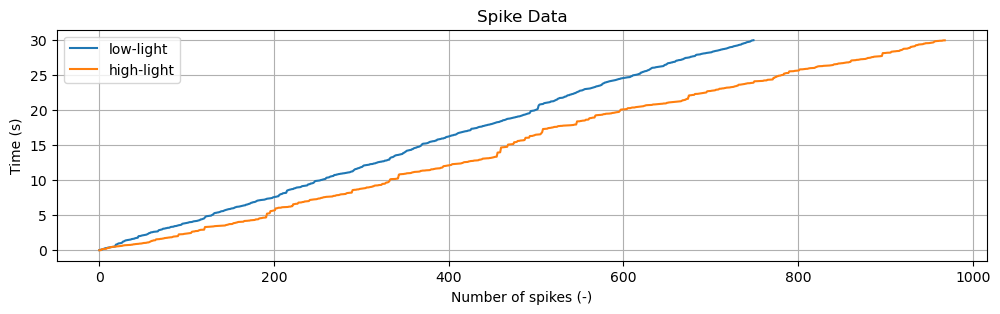

In [4]:
# Q2.1 CODE
fig, ax = plt.subplots(1, 1)

ax.plot(spikes_low, label='low-light')
ax.plot(spikes_high, label='high-light')


ax.set_title('Spike Data')
ax.set_xlabel('Number of spikes (-)')
ax.set_ylabel('Time (s)')
ax.grid()
ax.legend()

plt.show()


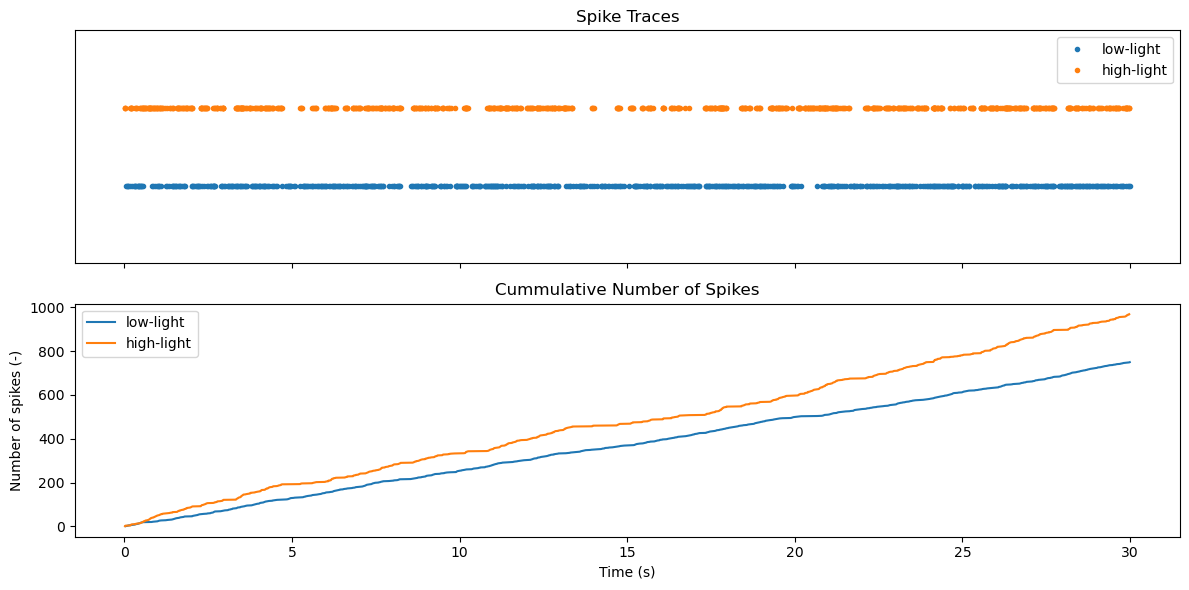

In [5]:
# Q2.2 CODE
import numpy as np

fig_trace, (ax1, ax2) = plt.subplots(2, 1, figsize = (12, 3*2), sharex = True)

low_spikes = np.ones_like(spikes_low)
high_spikes = np.ones_like(spikes_high)

ax1.plot(spikes_low, low_spikes, ls = '', marker = '.', label = 'low-light')
ax1.plot(spikes_high, high_spikes*2, ls = '', marker = '.', label = 'high-light')

ax1.set_title('Spike Traces')
ax1.set_yticks([])
ax1.legend()
ax1.set_ylim((0, 3))


ax2.set_title('Cummulative Number of Spikes')
ax2.plot(spikes_low, np.cumsum(low_spikes), label = 'low-light')
ax2.plot(spikes_high, np.cumsum(high_spikes), label = 'high-light')

ax2.set_ylabel('Number of spikes (-)')
ax2.set_xlabel('Time (s)')
ax2.legend()

plt.tight_layout()
plt.show()

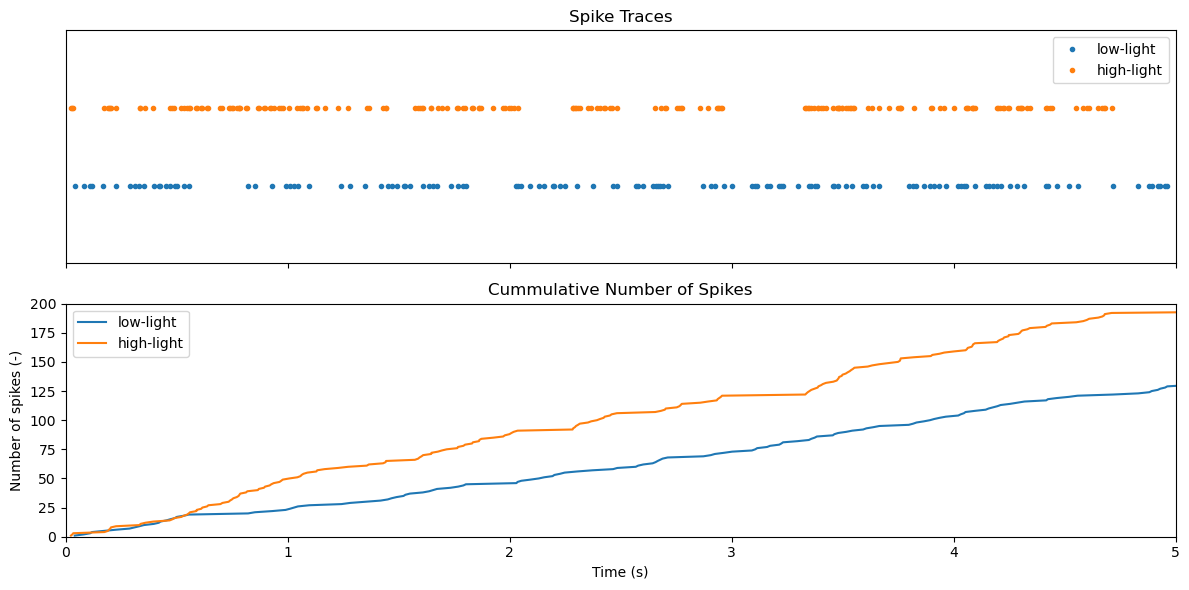

In [6]:
# ZOOM IN ON PLOT ABOVE

fig_trace, (ax1, ax2) = plt.subplots(2, 1, figsize = (12, 3*2), sharex = True)

low_spikes = np.ones_like(spikes_low)
high_spikes = np.ones_like(spikes_high)

ax1.plot(spikes_low, low_spikes, ls = '', marker = '.', label = 'low-light')
ax1.plot(spikes_high, high_spikes*2, ls = '', marker = '.', label = 'high-light')

ax1.set_title('Spike Traces')
ax1.set_yticks([])
ax1.legend()
ax1.set_ylim((0, 3))


ax2.set_title('Cummulative Number of Spikes')
ax2.plot(spikes_low, np.cumsum(low_spikes), label = 'low-light')
ax2.plot(spikes_high, np.cumsum(high_spikes), label = 'high-light')

ax2.set_ylabel('Number of spikes (-)')
ax2.set_xlabel('Time (s)')
ax2.legend()

for ax in (ax1, ax2):
    ax.set_xlim((0, 5))

ax2.set_ylim((0, 200))

plt.tight_layout()
plt.show()

<div class="alert alert-success">
<span style="color:black">


    
<!-- \begin{tcolorbox}[colback=green!5] -->
**A2 conclusion** 

1. By plotting `spikes_low` and `spikes_high`, one can see that the the elapsed time ($y$-axis) is plotted in function of the (cummulative) number of spikes ($x$-axis).

2. A second approach involved creating a dot-raster plot displaying spike traces from both low- and high-light conditions, with each dot representing a spike occurrence. Beneath the dot-raster, a plot was included to visualize the cumulative number of spikes ($y$-axis) over time ($x$-axis), enabling a more quantitative analysis.

   Upon analyzing the spike data from both low and high-light conditions, significant differences in spiking patterns emerge. Across the entire 30-second recording period, it's evident that the high-light condition exhibits a higher overall spike count compared to the low-light condition. This discrepancy suggests that the lighting conditions indeed influence the neural activity, with brighter environments leading to increased spiking rates.

   Furthermore, a closer examination reveals distinct spiking patterns between the two conditions. In the low-light condition, the spiking pattern appears more regular, characterized by a relatively linear cumulative spike count plot. While occasional periods of spiking followed by no spiking are observed, overall, the spiking activity demonstrates a consistent rhythm.

   In contrast, the high-light condition displays a less regular spiking pattern, characterized by intermittent bursts of rapid spiking interspersed with longer periods of no spiking. This bursting firing pattern is evident in both the cumulative spike count plot and the dot-raster plot, where clusters of spikes are followed by intervals of 'silence'.

<!-- \end{tcolorbox} -->
    
</span>

#### A3: Spike Rates  <a id="A3"></a>
* [Go back to Q3](#Q3)   

In [7]:
# Hint: if you use np.arange (as suggested), make sure that also your end time is included in the range.
# Hint: you can also use np.linspace, make sure that you want the number of time_edges of the bins, not the number of bins.
# Hint: you can use plt.hist() to plot but dont use plt.hist() to calculate the histogram values because it returns floating numbers, which will give troubles in your future calculations.

# Use the following variables:
#increments_low_50
#increments_high_50
#time_bin_edges
#bins_low_4spikes
#bins_low_0spikes
#bins_high_4spikes
#bins_high_0spikes

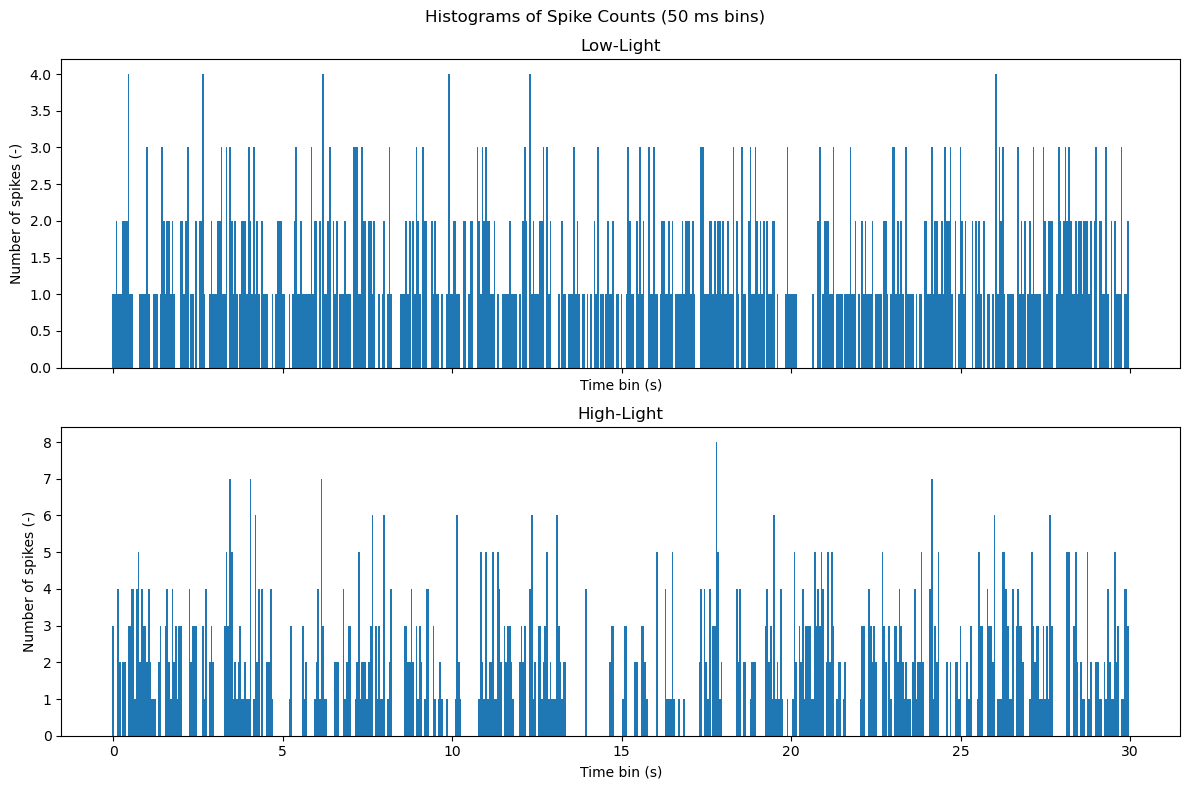

In [8]:
# Q3.1  CODE
# make histograms
dt = 50e-3
time_bin_edges = np.arange(0, 30 + dt, dt)
increments_low_50, _ = np.histogram(spikes_low, bins = time_bin_edges)
increments_high_50, _ = np.histogram(spikes_high, bins = time_bin_edges)

# bins with 4 spikes
bins_low_4spikes = increments_low_50[increments_low_50 == 4]
bins_high_4spikes = increments_high_50[increments_high_50 == 4]

# bins with 0 spikes
bins_low_0spikes = increments_low_50[increments_low_50 == 0]
bins_high_0spikes = increments_high_50[increments_high_50 == 0]

# Plot histogram of spike counts for low- and high-light conditions
fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (12, 4*2), sharex = True)

plt.suptitle('Histograms of Spike Counts (50 ms bins)')

ax1.set_title('Low-Light')
ax1.bar(time_bin_edges[:-1], increments_low_50, width = dt)

ax2.set_title('High-Light')
ax2.bar(time_bin_edges[:-1], increments_high_50, width = dt)

for ax in (ax1, ax2):
    ax.set_xlabel('Time bin (s)')
    ax.set_ylabel('Number of spikes (-)')

plt.tight_layout()
plt.show()

In [9]:
N = increments_low_50.shape[0]
dN = 100
bin_edges_av = np.arange(dN) * dt

low_50_epochs = increments_low_50.reshape((dN, N // dN))
low_50_av = np.mean(low_50_epochs, axis = 1)
low_50_std = np.std(low_50_epochs, axis = 1)


high_50_epochs = increments_high_50.reshape((dN, N // dN))
high_50_av = np.mean(high_50_epochs, axis = 1)
high_50_std = np.std(high_50_epochs, axis = 1) **2 

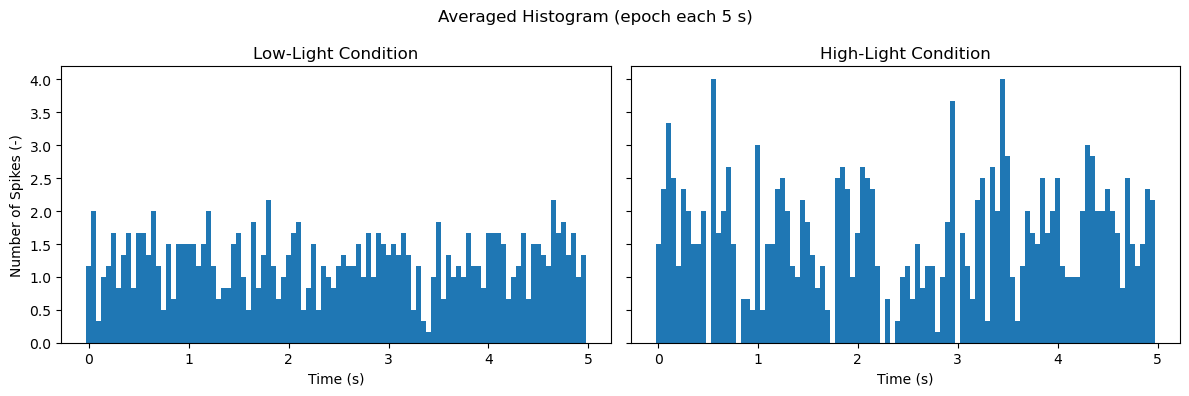

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (6*2, 4), sharey = True)

plt.suptitle('Averaged Histogram (epoch each 5 s)')

ax1.set_title('Low-Light Condition')
ax1.bar(bin_edges_av, low_50_av, width = dt)
ax1.set_ylabel('Number of Spikes (-)')
ax1.set_xlabel('Time (s)')

ax2.set_title('High-Light Condition')
ax2.bar(bin_edges_av, high_50_av, width = dt)
ax2.set_xlabel('Time (s)')


plt.tight_layout()
plt.show()

In [11]:
FF_epochs_low = low_50_av.var() / low_50_av.mean()
FF_epochs_high = high_50_av.var() / high_50_av.mean()

print('FF as Reproducability Metric:')
print(f'Low:\t{FF_epochs_low:.3f}')
print(f'High:\t{FF_epochs_high:.3f}')

FF as Reproducability Metric:
Low:	0.147
High:	0.498


In [12]:
print('For Low-light:')
print(f'There are {len(bins_low_0spikes):1.0f} bins with 0 spikes.')
print(f'There are {len(bins_low_4spikes):1.0f} bins with 4 spikes.')

print('\nFor High-light:')
print(f'There are {len(bins_high_0spikes):1.0f} bins with 0 spikes.')
print(f'There are {len(bins_high_4spikes):1.0f} bins with 4 spikes.')

For Low-light:
There are 136 bins with 0 spikes.
There are 6 bins with 4 spikes.

For High-light:
There are 226 bins with 0 spikes.
There are 44 bins with 4 spikes.


In [13]:
# Q3.2 CODE
FF_low50 = increments_low_50.var() / increments_low_50.mean()
FF_high50 = increments_high_50.var() / increments_high_50.mean()

print(f'The FF for the low-light is: {FF_low50:.2f}')
print(f'The FF for the high-light is: {FF_high50:.2f}')

The FF for the low-light is: 0.72
The FF for the high-light is: 1.78


<div class="alert alert-success">
<span style="color:black">

<!-- \begin{tcolorbox}[colback=green!5] -->
**A3 conclusion** 

In the low-light condition, the histogram appears relatively uniform in time, indicating a more regular spiking pattern (lower variability in spike counts over time). Uniformity is also seen in the binnend counts, yielding a higher variability of binned counts: the counts are somewhere between 0-2 on average. 

Conversely, the histogram for the high-light condition exhibits dense patches with elevated bin counts interspersed with regions of low or zero counts. This pattern suggests a rhythmic spiking pattern, characterized by bursts followed by refractory periods, which extends 'periodically' throughout the recording duration (higher variability of the spike counts in time). This means that *or* the bin count is *high*, *or* the bin count is *low*, indicating the lower variability in the binned counts.

Quantitative analysis further supports these observations made about the variability of the binnend counts, with the high-light condition demonstrating a greater number of bins with both four and zero spikes compared to the low-light condition.

The computed Fano Factors further reinforce the findings about the spike counts variability in time, with values of 0.72 and 1.78 for the low-light and high-light conditions, respectively. Interpretation of the FF highlights the more regular spiking in the low-light condition (less variability in time) compared to the higher variability (in time) observed in the high-light condition (discussed further in Conclusion 4.1).

The tabulated numerical results provide a summary of the observed differences in bin counts and FF values between the two conditions:

|            |   bins with 4 spikes  |   bins with 0 spikes  |   Fano Factor 50 ms bins | Fano Factor Reproducability |
|------------|-----------------------|-----------------------|--------------------------| --------------------------- |
| low-light  |                     6 |                   136 |               0.72       | 0.34                        |
| high-light |                    44 |                   226 |               1.78       | 0.55                        |

<!-- \end{tcolorbox} -->


</span>

#### A4: Fano Factor  <a id="A4"></a>
* [Go back to Q4](#Q4)   

In [14]:
from scipy.stats import gamma   # Import the gamma object from the SciPy stats toolbox

# Use the following variables:
#ppf_low_50 (an array with 2 values: the lower and upper percentile)
#ppf_high_50
#ppf_low_25
#ppf_high_25
#ppf_low_100
#ppf_high_100
#ppf_low_500
#ppf_high_500

def gamma_function(spike_data, binsize, T = 30, plot = False, plot_title = ''):
    
    # bin spike_data depending on specified binsi (in seconds)
    time_bin_edges = np.arange(0, T + binsize, binsize)
    increments, _ = np.histogram(spike_data, bins = time_bin_edges)
    FF = increments.var() / increments.mean()

    # construct gamma distribution
    N = len(time_bin_edges) - 1
    a = (N - 1) / 2       
    scale = 2 / (N - 1)   
    FF_distr = gamma(a, scale = scale)

    # calculate CI bounds
    ppf = FF_distr.ppf([0.025, 0.975])

    if plot:
        x = np.linspace(FF_distr.ppf(0.001), FF_distr.ppf(0.999), 200)
        
        plt.figure()
        
        if plot_title == '':
            plt.title('PDF of gamma distribution ' + rf'$\Gamma({a:.2f}, {scale:.2f})$')
        else:
            plt.title(plot_title)
        plt.plot(x, FF_distr.pdf(x), label = 'pdf')
        plt.vlines(ppf, ymin = [0, 0], ymax = [FF_distr.pdf(ppfi) for ppfi in ppf], ls = '--', color = 'red', label = 'CI bounds')
        plt.axvline(x = FF, ymin = 0, ymax = 1.0, ls = '--', color = 'black', label  = f'FF = {FF:.2f}')
        
        plt.legend()
        plt.show()

    return ppf, FF



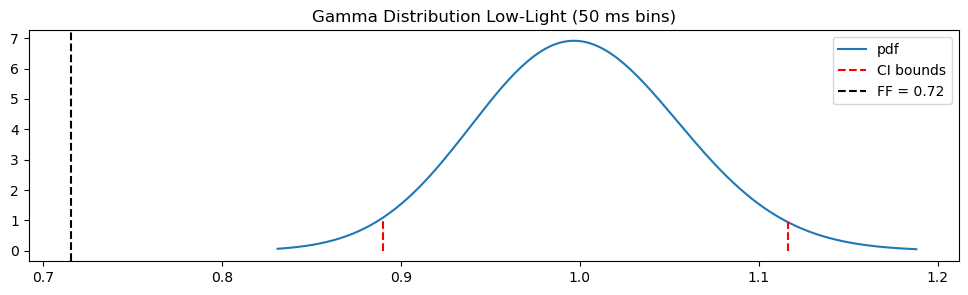

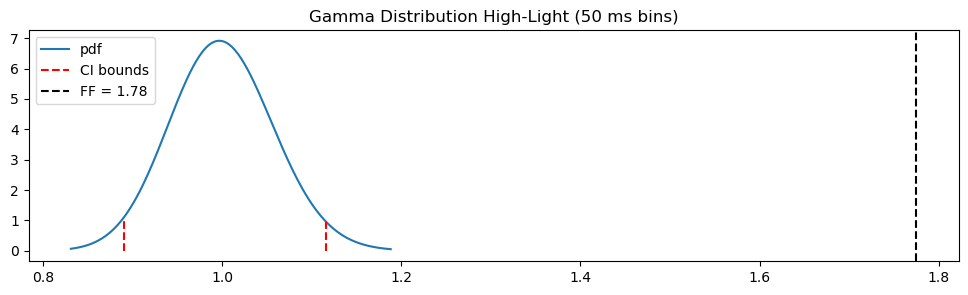

Is FF for low-light condition within CI bounds? False
Is FF for high-light condition within CI bounds? False


In [15]:
# Q4.2 CODE
dt1 = 50e-3
ppf_low_50, FF_low_50 = gamma_function(spikes_low, dt, T = 30, plot = True, plot_title = 'Gamma Distribution Low-Light (50 ms bins)')
ppf_high_50, FF_high_50 = gamma_function(spikes_high, dt, T = 30, plot = True, plot_title = 'Gamma Distribution High-Light (50 ms bins)')

# Determine if FFs fall within confidence interval bounds
is_low_in_ci = ppf_low_50[0] <= FF_low_50 <= ppf_low_50[-1]
is_high_in_ci = ppf_high_50[0] <= FF_high_50 <= ppf_high_50[-1]

print("Is FF for low-light condition within CI bounds?", is_low_in_ci)
print("Is FF for high-light condition within CI bounds?", is_high_in_ci)



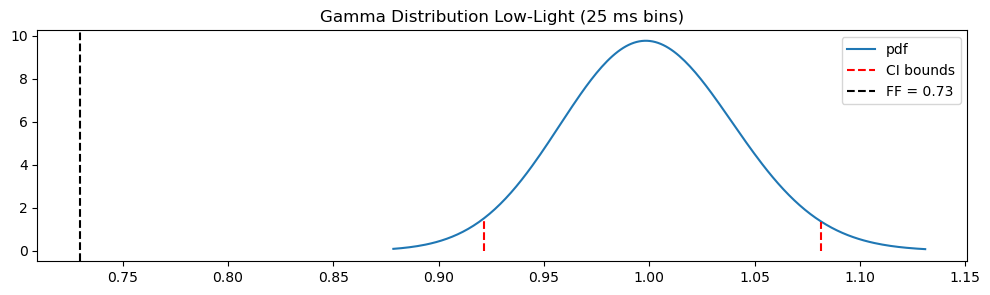

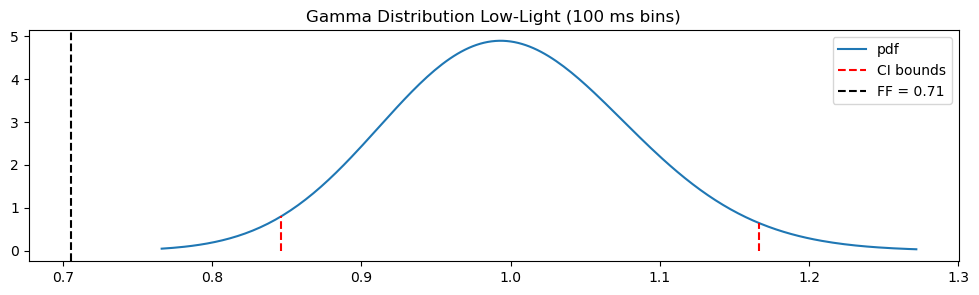

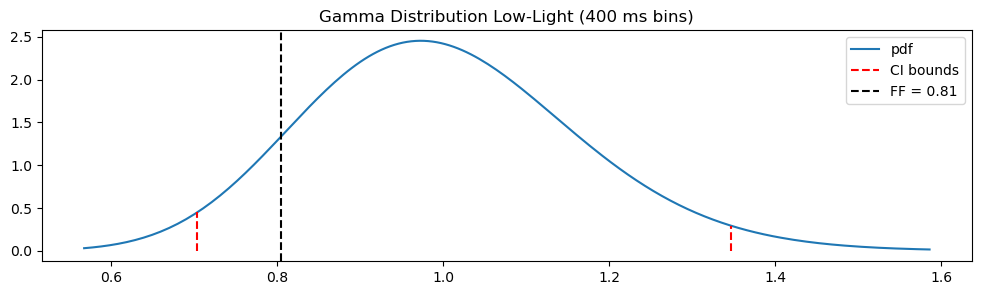

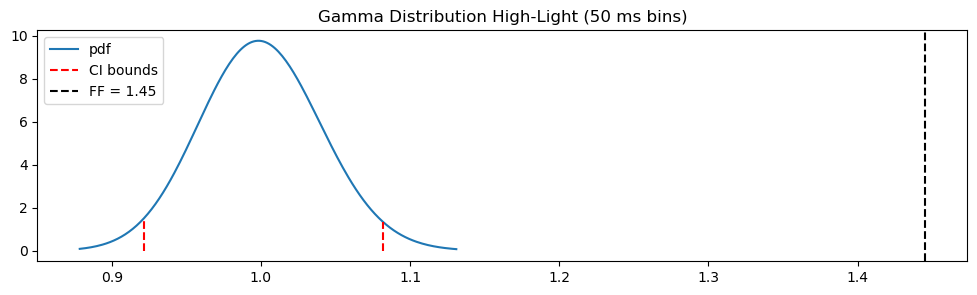

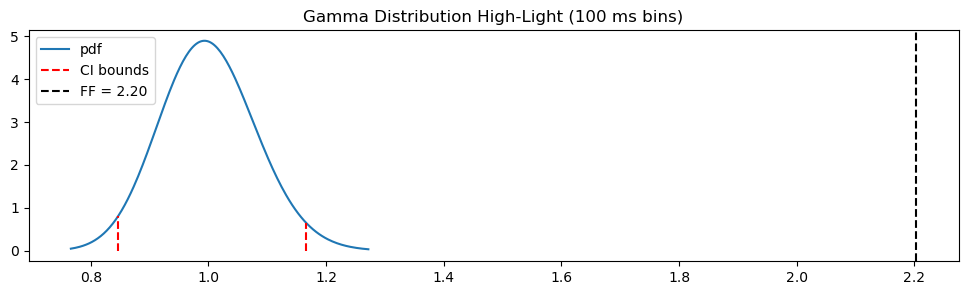

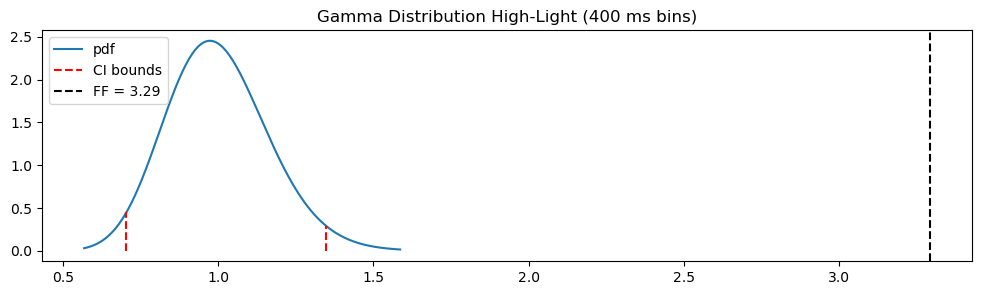

,2.5 Percentile,97.5 Percentile,Fano Factor (FF),Sign. from Poisson
low-light 25 ms,0.922,1.082,0.730,True
low-light 100 ms,0.846,1.167,0.705,True
low-light 400 ms,0.704,1.347,0.805,False
high-light 25 ms,0.922,1.082,1.445,True
high-light 100 ms,0.846,1.167,2.203,True
high-light 400 ms,0.704,1.347,3.292,True


In [16]:
# Q4.3 CODE
import pandas as pd

# Calculate CI boundaries and FF for each binsize (25ms, 50ms, 100ms and 500ms)
ppf_low_25, FF_low_25 = gamma_function(spikes_low, binsize = 0.025, plot = True, plot_title = 'Gamma Distribution Low-Light (25 ms bins)')
ppf_low_100, FF_low_100 = gamma_function(spikes_low, binsize = 0.100, plot = True, plot_title = 'Gamma Distribution Low-Light (100 ms bins)')
ppf_low_400, FF_low_400 = gamma_function(spikes_low, binsize = 0.400, plot = True, plot_title = 'Gamma Distribution Low-Light (400 ms bins)')

ppf_high_25, FF_high_25 = gamma_function(spikes_high, binsize = 0.025, plot = True, plot_title = 'Gamma Distribution High-Light (50 ms bins)')
ppf_high_100, FF_high_100 = gamma_function(spikes_high, binsize = 0.100, plot = True, plot_title = 'Gamma Distribution High-Light (100 ms bins)')
ppf_high_400, FF_high_400 = gamma_function(spikes_high, binsize = 0.400, plot = True, plot_title = 'Gamma Distribution High-Light (400 ms bins)')

# Return clear table
bounds = np.array([ppf_low_25, ppf_low_100, ppf_low_400,
    ppf_high_25, ppf_high_100, ppf_high_400])
FF = np.array([FF_low_25, FF_low_100, FF_low_400,
    FF_high_25, FF_high_100, FF_high_400])

dict = {
    "2.5 Percentile": bounds[:,0].round(3),
    "97.5 Percentile": bounds[:,1].round(3),
    "Fano Factor (FF)": FF.round(3),
    "Sign. from Poisson": (FF < bounds[:,0]) | (bounds[:,1] < FF)
    }
index = [
    'low-light 25 ms',
    'low-light 100 ms',
    'low-light 400 ms',
    'high-light 25 ms',
    'high-light 100 ms',
    'high-light 400 ms'
    ]
df = pd.DataFrame(dict, index=index)
display(df)
    

<div class="alert alert-success">
<span style="color:black">


<!-- \begin{tcolorbox}[colback=green!5] -->

**A4.1 Conclusion** 

The Fano Factor can be interpreted in two ways
1. As a statistic that describes the variability of the spike counts over time. I.e. it quantifies how regular a spiking pattern is, meaning that given that a spike occured, can we predict when the next spike will be produced? For this part, we related the obtained FF with 1, which is the FF for a poisson process.
2. As a measure for the reproducability of a spike pattern. 

In the low-light condition, the Fano Factor is observed to be smaller than 1. This finding suggests that the spiking process exhibits a higher degree of regularity compared to a Poisson process. This could be attributed to factors such as the refractory period, where the absence of spiking for a certain duration acts to reduce variance $^1$.

Conversely, in the high-light condition, the Fano Factor exceeds 1. This indicates that additional factors beyond Poisson noise contribute to the observed variability. Indeed, these factors cause these spike bursts.

$^1$ This is known as the *regularizing effect* of the refractory period. 
<!-- \end{tcolorbox} -->
    
</span>

<div class="alert alert-success">
<span style="color:black">

<!-- \begin{tcolorbox}[colback=green!5] -->
**A4 conclusion** 

The examination of the Fano Factor (FF) plots in Q4.2 and Q4.3 offers valuable insights into the spiking dynamics under different light conditions.

For the low-light condition, the FF is significantly less than one for bin sizes of 25 and 100 ms, indicating a more regular spiking pattern compared to a Poisson process (as discussed in **Conclusion 4.1**). However, for 400 ms bins, the PDF becomes broader, yielding a non-significant FF. This observation underscores the importance of bin size selection, as a larger bin size may not accurately capture the spiking variability due to refractoriness and other factors. While computing the FF for a 400 ms interval may not serve as a reliable comparison to a Poisson process (because we *know* that spiking *isn't* poisson-like), it can still provide insights into reproducibility (as defined in definition two of **Conclusion 4.1**). It's essential to exercise caution when interpreting the FF, considering the inherent limitations in larger bin sizes.

In contrast, the high-light condition exhibits a significantly higher FF than that of a Poisson process, indicating greater spiking variability (referenced in **Conclusion 4.1**).

We can see that the FF increase by increasing the bin size. The reason why is explained above.

<!-- \end{tcolorbox} -->
    
</span>

#### A5: Interspike Intervals  <a id="A5"></a>
* [Go back to Q5](#Q5)   

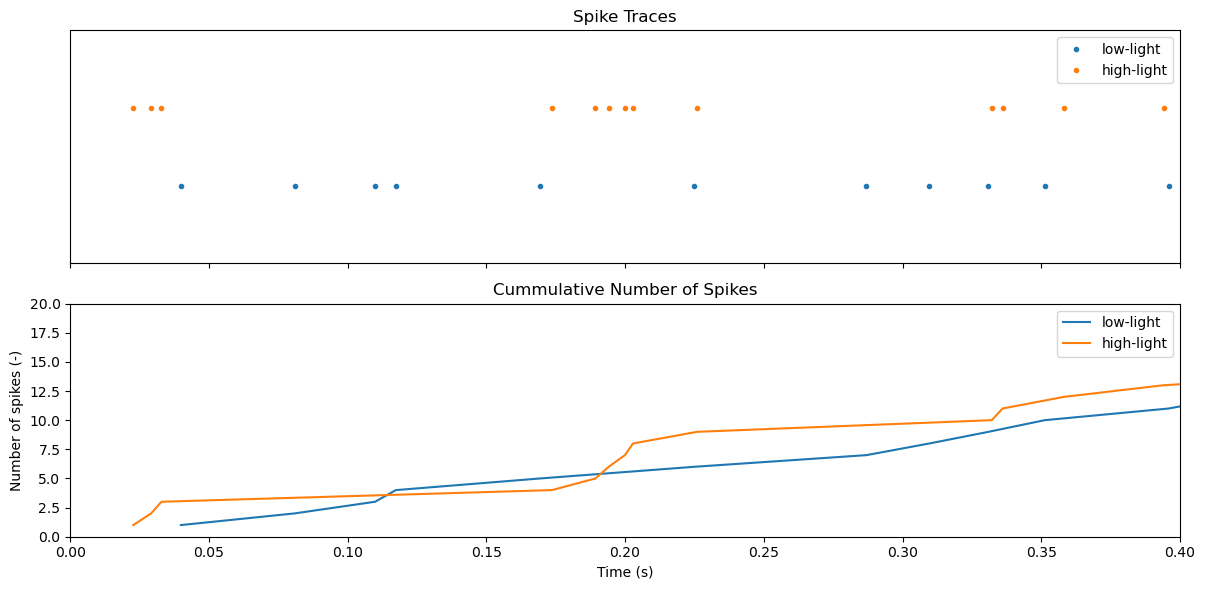

In [17]:
# Q5.1 CODE
# zoom in on plot made previously
plt.figure(fig_trace)
ax2.set_ylim((0, 100))
plt.xlim([0, 0.40])
plt.ylim((0, 20))
plt.show()

In [18]:
# Use the following variables: 

#ISI_low
#ISI_high
#ISI_hist_low_10
#ISI_hist_high_10
#ISI_hist_low_1
#ISI_hist_high_1

In [19]:
# Computations
ISI_low = np.diff(spikes_low)
ISI_high = np.diff(spikes_high)

dt_20 = 20e-3 
bins_low_20 = np.arange(0, ISI_low.max() + dt_20, dt_20)
bins_high_20 = np.arange(0, ISI_high.max() + dt_20, dt_20)

ISI_hist_low_20, _ = np.histogram(ISI_low, bins = bins_low_20)
ISI_hist_high_20, _ = np.histogram(ISI_high, bins = bins_high_20)

dt_2 = 2e-3 
bins_low_2 = np.arange(0, ISI_low.max() + dt_2, dt_2)
bins_high_2 = np.arange(0, ISI_high.max() + dt_2, dt_2)

ISI_hist_low_2, _ = np.histogram(ISI_low, bins = bins_low_2)
ISI_hist_high_2, _ = np.histogram(ISI_high, bins = bins_high_2)

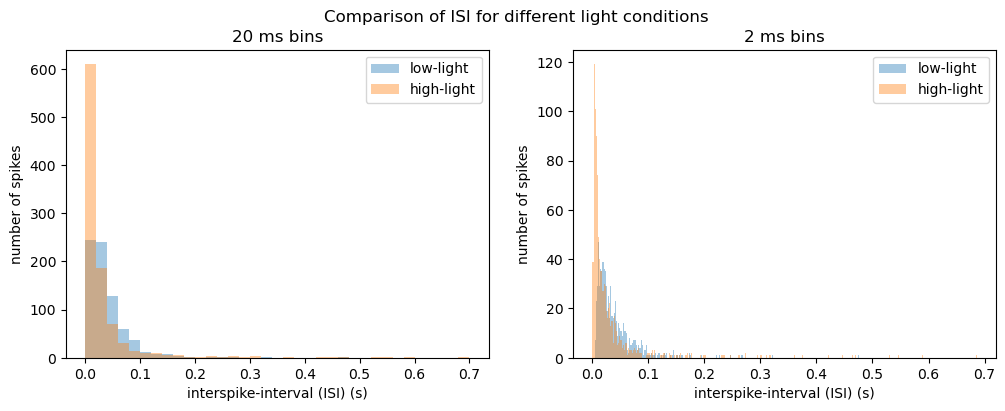

In [20]:
# histogram visualizations
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.hist(ISI_low, bins_low_20, alpha=0.4, label='low-light')
ax1.hist(ISI_high, bins_high_20, alpha=0.4, label='high-light')

ax2.hist(ISI_low, bins_low_2, alpha=0.4, label='low-light')
ax2.hist(ISI_high, bins_high_2, alpha=0.4, label='high-light')


ax1.set_title('20 ms bins')
ax1.set_xlabel('interspike-interval (ISI) (s)')
ax1.set_ylabel('number of spikes')
ax1.legend()
ax2.set_title('2 ms bins')
ax2.set_xlabel('interspike-interval (ISI) (s)')
ax2.set_ylabel('number of spikes')
ax2.legend()

plt.suptitle('Comparison of ISI for different light conditions')
plt.show()

In [21]:
# statistics
df_low = pd.DataFrame(ISI_low)
df_high = pd.DataFrame(ISI_high)

df_descr_stats = pd.concat([df_low[0].describe(), df_high[0].describe()], axis = 1, keys = ['ISI Low-Light', 'ISI High-Light'])
display(df_descr_stats)

,ISI Low-Light,ISI High-Light
count,749.000000,968.000000
mean,0.039988,0.030942
std,0.038583,0.062591
min,0.004009,0.000757
25%,0.016964,0.005765
50%,0.028927,0.012540
75%,0.050845,0.030399
max,0.475121,0.685734


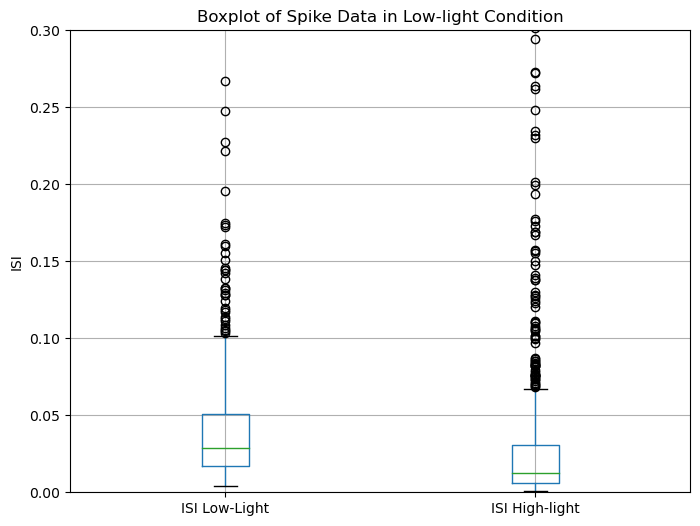

In [22]:
# make a boxplot
plt.figure(figsize = (8, 6))


pd.concat([df_low[0], df_high[0]], axis = 1, keys = ['ISI Low-Light', 'ISI High-light']).boxplot()

# Set labels and title
plt.ylabel('ISI')
plt.title('Boxplot of Spike Data in Low-light Condition')

plt.ylim((0, 0.3))

# Show the plot
plt.show()

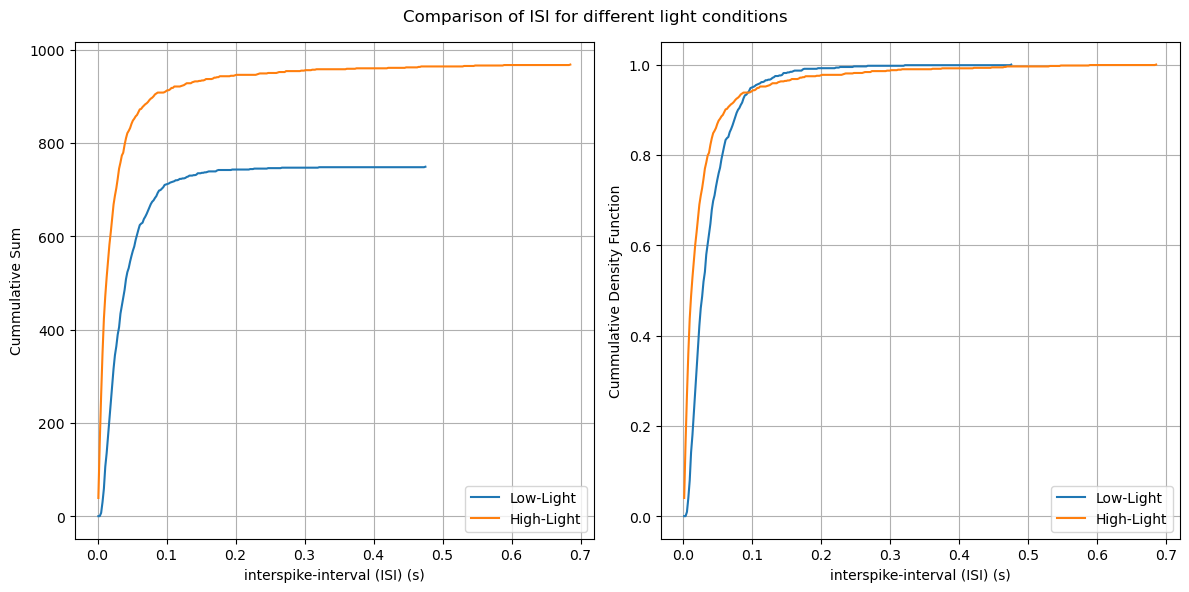

In [23]:
# cummulative distribution function
centers_bins_low_2 = (bins_low_2[:-1] + bins_low_2[1:])/2
centers_bins_high_2 = (bins_high_2[:-1] + bins_high_2[1:])/2
N_high, N_low = np.sum(ISI_hist_high_2), np.sum(ISI_hist_low_2) 


fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (6*2, 6))

plt.suptitle('Comparison of ISI for different light conditions')

ax1.plot(centers_bins_low_2, ISI_hist_low_2.cumsum() , label = 'Low-Light')
ax1.plot(centers_bins_high_2, ISI_hist_high_2.cumsum(), label = 'High-Light')

ax1.set_xlabel('interspike-interval (ISI) (s)')
ax1.set_ylabel('Cummulative Sum')
ax1.legend()
ax1.grid()

ax2.plot(centers_bins_low_2, ISI_hist_low_2.cumsum() / N_low , label = 'Low-Light')
ax2.plot(centers_bins_high_2, ISI_hist_high_2.cumsum() / N_high, label = 'High-Light')

ax2.set_xlabel('interspike-interval (ISI) (s)')
ax2.set_ylabel('Cummulative Density Function')
ax2.legend()
ax2.grid()

plt.tight_layout()
plt.show()


<div class="alert alert-success">
<span style="color:black">


<!-- \begin{tcolorbox}[colback=green!5] -->
**A5 conclusion** 
    
Observation of the ISI histogram gives following observations:

- Both histograms are positively skewed due to the ISI being positive semidefinite and the higher counts observed for low ISIs.
- There are more spike ISI (spike) counts for the high-light condition.
- The ISI histogram of the low-light condition shows less variability (thinner). You can also see this in the boxplots.
- The mean ISI value of the low light condition is higher than the one of the high light condition. So, on average, the spiking rate in the high light condition is higher.

As aforemention, the spiking pattern in the high-light condition is characterised by periods of rapid spiking (bursts) followed by a longer recovery period (low-light Cummulative Density Function crosses the high-light Cummulative Density Function around 0.95 ms). In contrast, the low-light condtion behaves more regular (poisson-like). I.e. there is a wider range of ISIs. (Actually, this question is answered already in previous conclusions.)

<!-- \end{tcolorbox} -->
    
</span>

#### A6: Autocorrelation functions (ACF) <a id="A6"></a>
* [Go back to Q6](#Q6)  

In [24]:
# Hint: when using the np.correlate(,'full') function, the location of your first lag at lag 0 (t = 0) is at index xcorr.size // 2, figure out why.

#use the following variables:
#ACF_low_50 
#ACF_high_50 
#ACF_low_1
#ACF_high_1

def autocorr(x, binsize = 50e-3, lags = 0, T = 30):
    # Discretize the data
    bins = np.arange(0, T + binsize, binsize)
    x_hist, _ = np.histogram(x, bins = bins)

    # Calculate autocorrelation for defined lags
    mean, var = x_hist.mean(), x_hist.var()
    ndata = x_hist - mean
    x_corr = np.correlate(ndata, ndata, 'full')
    x_corr = x_corr[x_corr.size//2:]
    x_corr = x_corr / var / len(ndata)

    # Calculate CI boundary
    N = len(x_hist)
    CI_bound = 2/np.sqrt(N)
    
    return x_corr[:lags+1], CI_bound 


In [25]:
# Q6.1 CODE
# Compute the autocorrelation functions
ACF_low_50, CI_low_50 = autocorr(spikes_low, binsize = 50e-3, lags = 3)
ACF_high_50, CI_high_50 = autocorr(spikes_high, binsize = 50e-3, lags = 3)

print(f"""
ACF_high_50: {np.round(ACF_high_50, 4)}
ACF_low_50:  {np.round(ACF_low_50, 4)}
CI boundary low: {CI_low_50:.4f}
CI boundary high: {CI_high_50:.4f}
""")


ACF_high_50: [1.     0.2425 0.082  0.0464]
ACF_low_50:  [1.     0.0386 0.0701 0.0425]
CI boundary low: 0.0816
CI boundary high: 0.0816



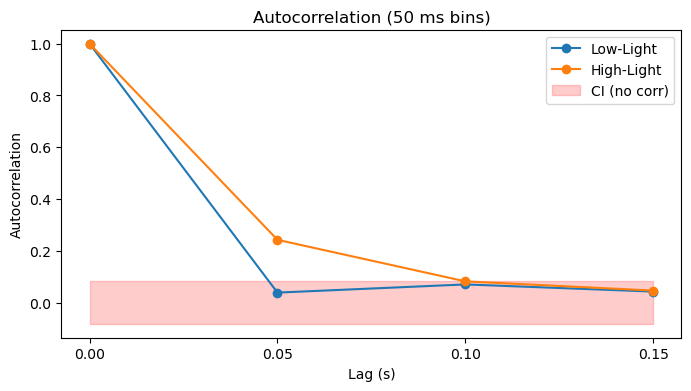

In [26]:
# Q6.2 CODE
fig, ax = plt.subplots(1, 1, figsize = (8, 4))

ax.set_title('Autocorrelation (50 ms bins)')

lags = np.arange(0, len(ACF_low_50), 1) * 50e-3
ax.plot(lags, ACF_low_50, marker = 'o', label = 'Low-Light')
ax.plot(lags, ACF_high_50, marker = 'o', label = 'High-Light')

ax.fill_between(lags, -CI_low_50, CI_low_50, color = 'red', alpha = 0.2, label = 'CI (no corr)')

ax.set_xticks(lags)
ax.set_xlabel('Lag (s)')

ax.set_ylabel('Autocorrelation')

ax.legend()
plt.show()

In [27]:
# Q6.3 CODE
# Compute the autocorrelation functions
ACF_low_1, CI = autocorr(spikes_low, binsize = 1e-3, lags = 100)
ACF_high_1, _ = autocorr(spikes_high, binsize = 1e-3, lags = 100)

ACF_1 = pd.concat([pd.DataFrame(ACF_low_1)[0], pd.DataFrame(ACF_high_1)[0]], axis = 1, keys = ['C_xx Low-Light', 'C_xx High-Light'])
display(ACF_1.describe())

,C_xx Low-Light,C_xx High-Light
count,101.000000,101.000000
mean,0.009498,0.019842
std,0.099869,0.098944
min,-0.025645,-0.015250
25%,-0.003672,0.004126
50%,-0.000926,0.009414
75%,0.004491,0.014598
max,1.000000,1.000000


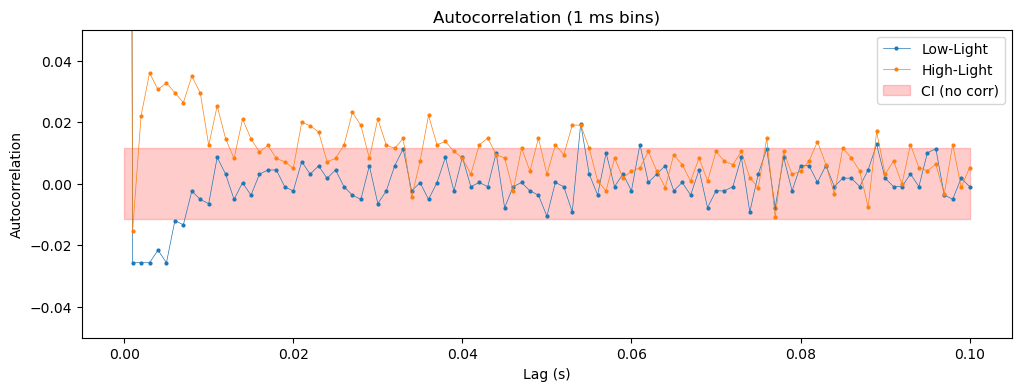

In [28]:
fig, ax = plt.subplots(1, 1, figsize = (12, 4))

ax.set_title('Autocorrelation (1 ms bins)')

lags = np.arange(0, len(ACF_low_1), 1) * 1e-3
ax.plot(lags, ACF_low_1, ls = '-', linewidth = 0.5, marker = 'o', markersize = 2, label = 'Low-Light')
ax.plot(lags, ACF_high_1, ls = '-', linewidth = 0.5, marker = 'o', markersize = 2, label = 'High-Light')

ax.fill_between(lags, -CI, CI, color = 'red', alpha = 0.2, label = 'CI (no corr)')

#ax.set_xticks(lags)
ax.set_xlabel('Lag (s)')

ax.set_ylim((-0.05, 0.05))
ax.set_ylabel('Autocorrelation')

ax.legend()
plt.show()

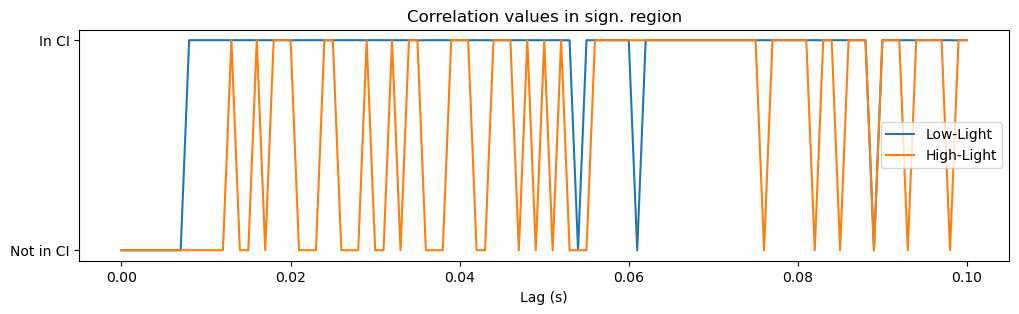

In [29]:
fig, ax = plt.subplots(1, 1)


ax.set_title('Correlation values in sign. region')
ax.plot(lags, np.where((ACF_low_1 >= -CI) & (ACF_low_1 <= CI), 1, 0), ls = '-', label = 'Low-Light')
ax.plot(lags, np.where((ACF_high_1 >= -CI) & (ACF_high_1 <= CI), 1, 0), ls = '-', label = 'High-Light')

ax.set_xlabel('Lag (s)')

ax.set_yticks([0, 1])
ax.set_yticklabels(['Not in CI', 'In CI'])

plt.legend()
plt.show()

In [30]:
# calculate how many values are within the boundaries
indices_within_ci_low = np.where((ACF_low_1 >= -CI) & (ACF_low_1 <= CI))[0]
indices_within_ci_high = np.where((ACF_high_1 >= -CI) & (ACF_high_1 <= CI))[0]

values_within_ci_low = ACF_low_1[indices_within_ci_low]
values_within_ci_high = ACF_high_1[indices_within_ci_high]

print(f'For the Low-Light condition: {len(values_within_ci_low)/len(ACF_low_1)*100:.2f}% inside the CI.')
print(f'For the High-Light condition: {len(values_within_ci_high)/len(ACF_high_1)*100:.2f}% inside the CI.')

For the Low-Light condition: 89.11% inside the CI.
For the High-Light condition: 58.42% inside the CI.


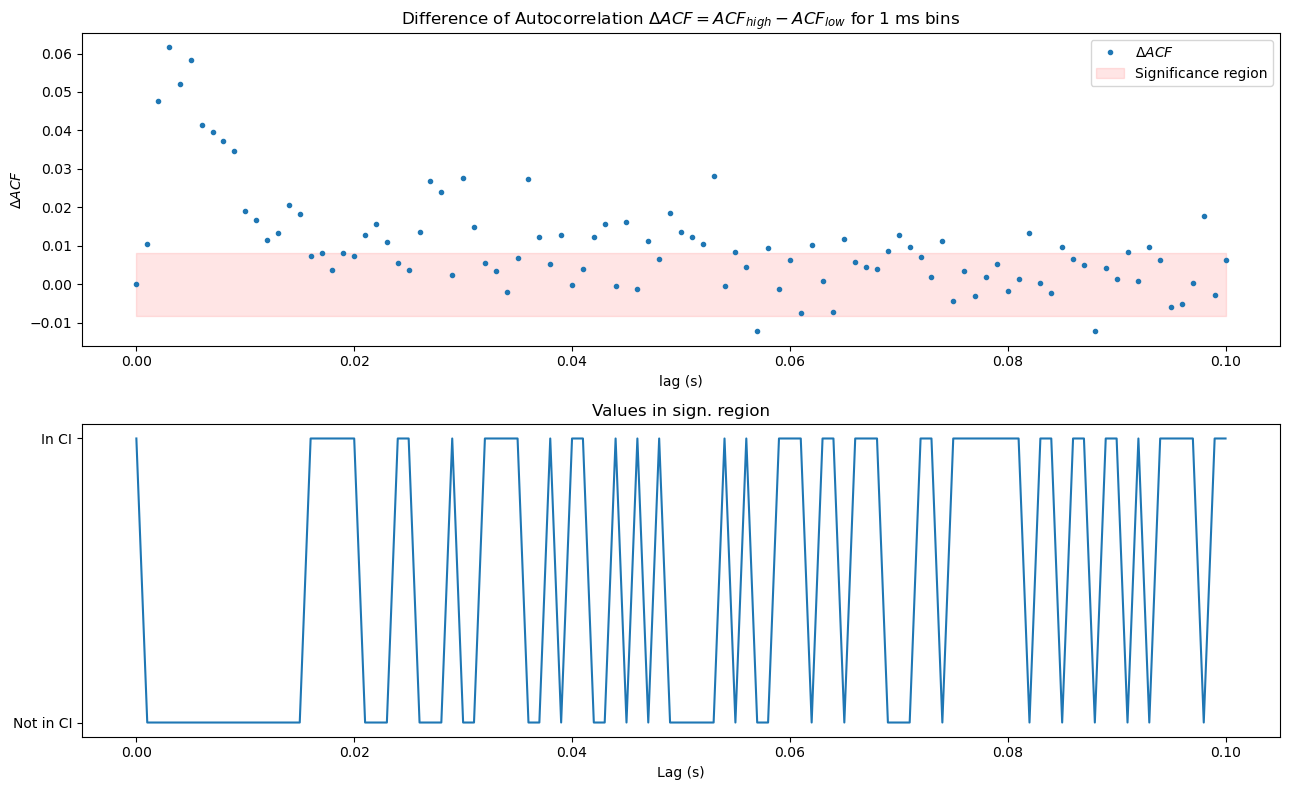

In [31]:
# Q6.4
Delta_ACF = ACF_high_1 - ACF_low_1 
N1 = 4 / CI**2
N2 = N1
CI_bound = np.sqrt(1/N1 + 1/N2)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (13, 4*2))

ax1.plot(lags, Delta_ACF, '.', label = r'$\Delta ACF$')
ax1.fill_between(lags, -CI_bound, CI_bound, color = 'red', alpha=0.1,
                label = 'Significance region')

ax1.set_title('Difference of Autocorrelation ' + r'$\Delta ACF = ACF_{high} - ACF_{low}$' + ' for 1 ms bins')
ax1.set_xlabel('lag (s)')
ax1.set_ylabel(r'$\Delta ACF$')
ax1.legend()

ax2.set_title('Values in sign. region')
ax2.plot(lags, np.where((Delta_ACF >= -CI_bound) & (Delta_ACF <= CI_bound), 1, 0), ls = '-')

ax2.set_xlabel('Lag (s)')

ax2.set_yticks([0, 1])
ax2.set_yticklabels(['Not in CI', 'In CI'])

plt.tight_layout()
plt.show()

<div class="alert alert-success">
<span style="color:black">


    
<!-- \begin{tcolorbox}[colback=green!5] -->
**A6.1 answer** 

For interpretation of the autocorrelation, lets consider the continuous autocorrelation.\
Consider an energy signal $x:\mathbb{R} \rightarrow \mathbb{R}$. Than the continuous autocorrelation $C_{x,x}(t) \in [\mathbb{R} \rightarrow \mathbb{R}]$ is defined as
$$
C_{x,x}(t) = \int_{-\infty}^{+\infty}x(\tau)x(\tau - t)\mathrm{d}\tau, \quad t \in \mathbb{R}.
$$
The overlap between $x$ and $x$ delayed over a time $t$, can be quantified by the analytical distance (norm) between those two functions:
$$
||x(\tau) - x(\tau - t)|| = \int_{-\infty}^{+\infty}\left( x(\tau) - x(\tau - t) \right)^2\mathrm{d}\tau.
$$

Expansion of the quadratic integrad gives

$$
 \int_{-\infty}^{+\infty}\left( x(\tau)^2 + x(\tau - t)^2 - 2 x(\tau)x(\tau - t) \right)^2\mathrm{d}\tau = C_{x, x}(0) + C_{x, x}(0) - 2C_{x, x}(t) = 2\left(C_{x, x}(0) - C_{x, x}(t)\right).
$$

Since the $ ||x(\tau) - x(\tau - t)|| \ge 0$ one becomes

$$
C_{x, x}(t) \le C_{x, x}(0).
$$

Now we can see that the maximum value of the autocorrelation is $C_{x, x}(0)$, the correlation of the signal with itself. This is obvious since you expect your signal to have the highest correlation with itself.

We can also see that 

$$
C_{x, x}(t) = C_{x, x}(0) - ||x(\tau) - x(\tau - t)||.
$$

From this mathematical detour you can basically conclude that the autocorrelationfunction is a meausere for the overlap, the correlation, between the signal $x$ and a delayed version of itself. If the correlation is high, 
$$
||x(\tau) - x(\tau - t)|| \rightarrow 0.
$$

So, lets go back to the descrite time estimate of the autocorrelation as defined in Q5. Its maximum value is at lag 0, indeed, with itself, and equals 1. 

At other lags, the ACF, represents the correlation (overlap) between the signal $x$ and a delayed (lagged) version of itself. It is thus usful to use the ACF, to see if the original signal can be found back in at later stages. Does it show some 'periodicity', meaning are their patterns that extent throughout the whole signal?


<!-- \end{tcolorbox} -->
    
</span>

<div class="alert alert-success">
<span style="color:black">


    
<!-- \begin{tcolorbox}[colback=green!5] -->
**A6.2 answer** 

The figure of the ACF with 50 ms bins indicates that for the high-light condition we see significant values for the autocorrelation values of lags 0 (trivial) and 50 ms. For the low-light condition, there are significant autocorrelation values to be observed only for 0 ms lag.

<!-- \end{tcolorbox} -->
    
</span>

<div class="alert alert-success">
<span style="color:black">


    
<!-- \begin{tcolorbox}[colback=green!5] -->
**A6.3 answer** 

On can see that due to the repeatitive (as mention in previous conclusions) bursting in the high-light condition, the ACF shows multiple signficance values throughout the recording. Indeed, the bursting process can be found back at different lags, hence the significance of the autocorrelation coefficients.

However, spiking in the low-light condition happens more randomly and does not show a distinct spiking (such as bursting) pattern. This is confirmed by the (most) autocorrelation values not being significant throughout the recording. You can also notice that the negative autocorrelation values are a result of the refractory period.

<!-- \end{tcolorbox} -->
    
</span>

<div class="alert alert-success">
<span style="color:black">
    
<!-- \begin{tcolorbox}[colback=green!5] -->
**A6.4 answer** 

In examining the autocorrelation differences between the high-light and low-light conditions, notable distinctions emerge. At lower lag values, particularly up to 15 ms, a significant discrepancy in autocorrelation is evident: spikes are more likely to occur in the high-light condition compared to the low-light condition within this time frame. As the lag increases to 55 ms, the observed autocorrelation differences persist, albeit with a reduced effect size. However, beyond the 55 ms threshold, the significance of the autocorrelation differences diminishes substantially, with fewer discernible variations between the two conditions.

<!-- \end{tcolorbox} -->
    
</span>

#### A7: Peri-stimulus-time histogram (PSTH)  <a id="A7"></a>
* [Go back to Q7](#Q7)  

In [32]:
# Load in the modules for this notebook and the data itself
from nitime.algorithms import multi_taper_psd
from nitime.utils import dpss_windows
import statsmodels.api as sm
from statsmodels.genmod.families import Poisson
import statsmodels.formula.api as smf
from pandas import DataFrame as df
from pandas import concat
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.stats import chi2, norm
rcParams['figure.figsize'] = (12,3)               # Change the default figure size

data2 = sio.loadmat('matfiles/10_spikes-1.mat') # Load the spike train data.
t = data2['t'][0]                         # Extract the t variable.
direction = data2['direction'].flatten()  # Extract the direction variable.
train = data2['train']                    # Extract the train variable

In [33]:
# The direction vector should contain 0 for a left trial and 1 for a right trial.
# The sum function provides an efficient method to do so: sum(direction) which returns a value of 25. 
# We conclude that half of the 50 trials involve right movement, and half involve left movement.
print(np.sum(direction))


25


In [34]:
# Q7.1 CODE
# group the data by direction
train_r = train[direction == 1]
train_l = train[direction == 0]
print(train_r.shape, train_l.shape)

(25, 2000) (25, 2000)


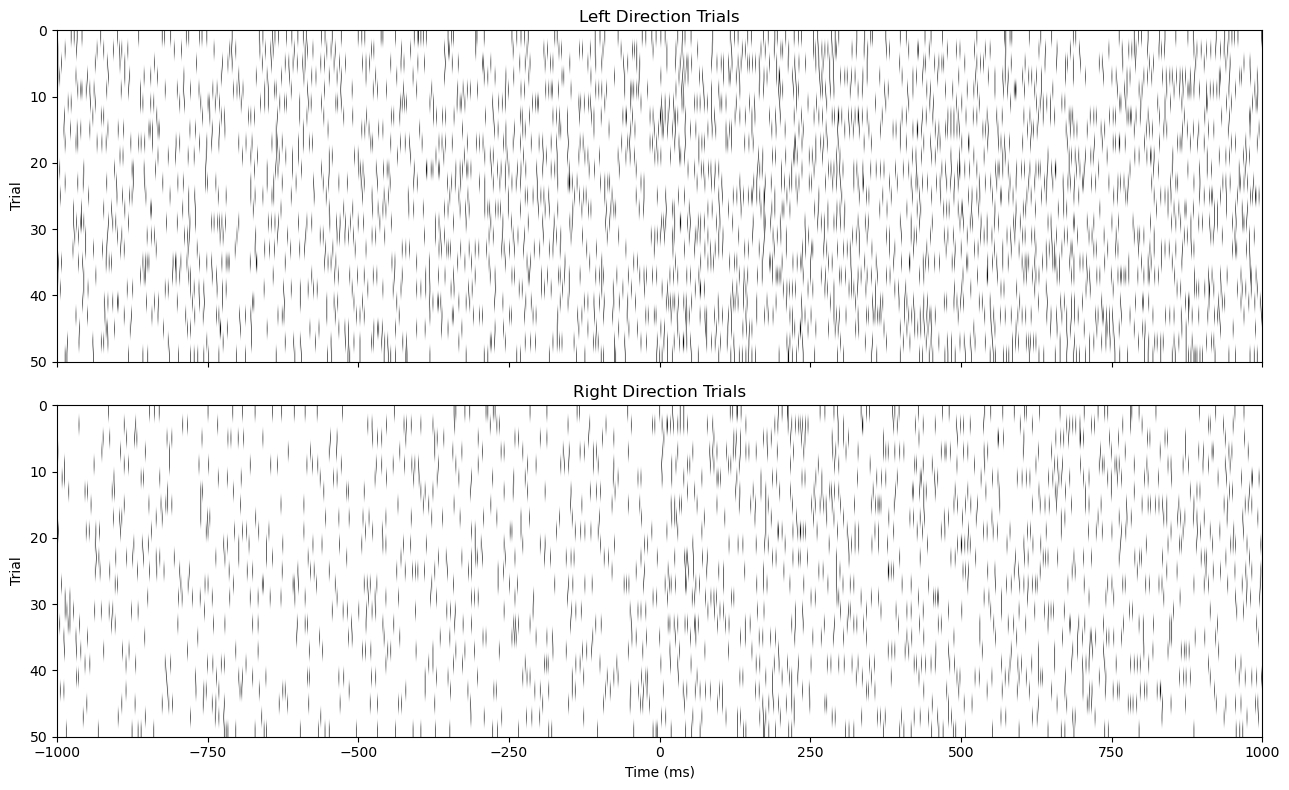

In [35]:
# Plotting the dot-raster plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (13, 4*2), sharex = True)

# Plot left direction trials

ax1.imshow(train_l, aspect = 'auto', cmap = 'binary', origin = 'lower',  extent = (-1000, 1000, 50, 0))
ax1.set_title('Left Direction Trials')
#ax1.set_xlabel('Time (ms)')
ax1.set_ylabel('Trial')

# Plot right direction trials
ax2.imshow(train_r, aspect = 'auto', cmap = 'binary', origin = 'lower', extent = (-1000, 1000, 50, 0))
ax2.set_title('Right Direction Trials')
ax2.set_xlabel('Time (ms)')
ax2.set_ylabel('Trial')

plt.tight_layout()
plt.show()

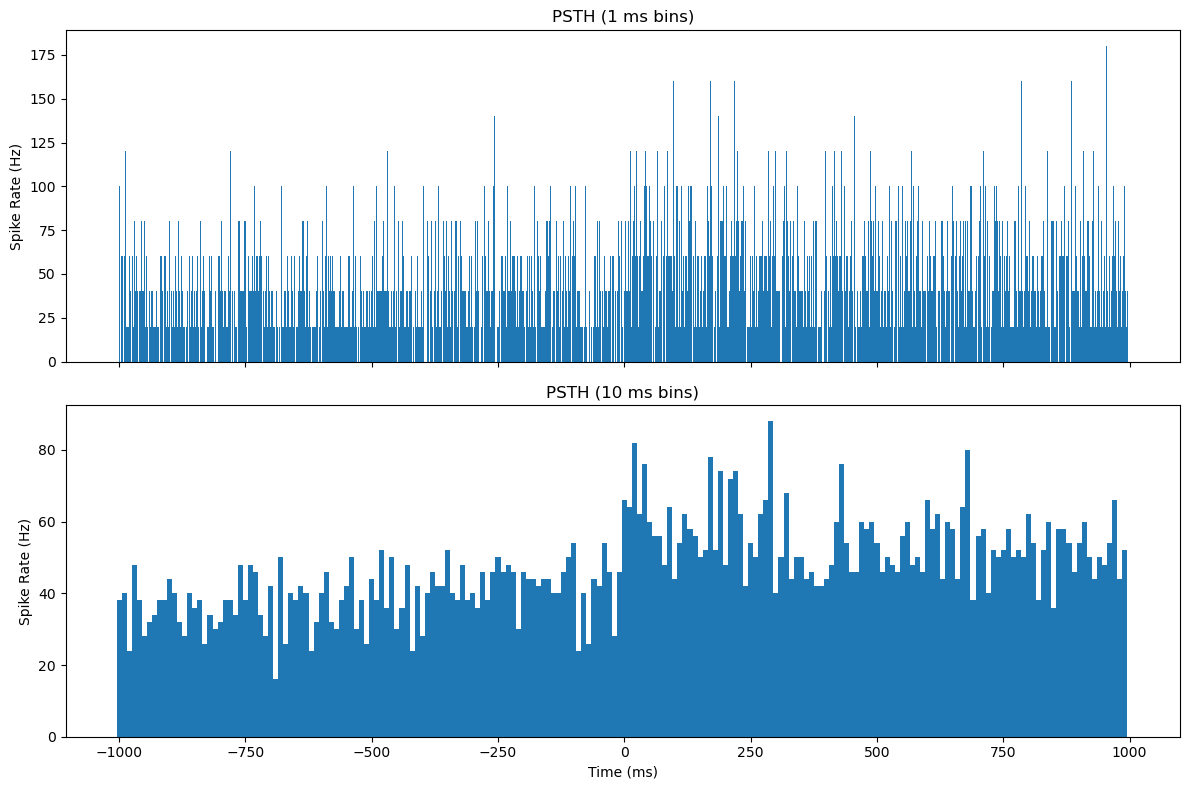

In [36]:
# Q7.2 CODE
# PSTH for 1 ms bins
PSTH_1ms = np.mean(train, axis = 0) / 1e-3
PSTH_1ms_l = np.mean(train_l, axis = 0) / 1e-3
PSTH_1ms_r = np.mean(train_l, axis = 0) / 1e-3

# PSTH for 10 ms bins
time_end, binsize, N = 1000, 10, len(t) 
time_bins_10ms = np.arange(-time_end, time_end, binsize)
PSTH_10ms = np.mean(train, axis = 0).reshape((N//binsize, binsize)).mean(axis = 1) * 1e3
PSTH_10ms_l = np.mean(train_l, axis = 0).reshape((N//binsize, binsize)).mean(axis = 1) * 1e3
PSTH_10ms_r = np.mean(train_r, axis = 0).reshape((N//binsize, binsize)).mean(axis = 1) * 1e3

# make a figure of it
fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (12, 2*4), sharex = True)

ax1.set_title('PSTH (1 ms bins)')
ax1.bar(t, PSTH_1ms, width = 1)


ax2.set_title('PSTH (10 ms bins)')
ax2.bar(time_bins_10ms, PSTH_10ms, width = 10)

for ax in (ax1, ax2):
    ax.set_ylabel('Spike Rate (Hz)')

ax2.set_xlabel('Time (ms)')

plt.tight_layout()
plt.show()

In [37]:
# Q7.3 CODE

# Define time indices for planning and movement periods
planning_period_indices = np.where(t < 0)[0]
movement_period_indices = np.where(t >= 0)[0]

# Compute overall averages
avg_rate_planning = train[:, planning_period_indices].mean()
avg_rate_movement = train[:, movement_period_indices].mean()

# Compute for L/R
avg_rate_l = train_l.mean()
avg_rate_r = train_r.mean()

# Compute average firing rates in planning and movement periods for left direction trials
avg_rate_planning_l = train_l[:, planning_period_indices].mean()
avg_rate_movement_l = train_l[:, movement_period_indices].mean()

# Compute average firing rates in planning and movement periods for right direction trials
avg_rate_planning_r = train_r[:, planning_period_indices].mean()
avg_rate_movement_r = train_r[:, movement_period_indices].mean()

# Print average firing rates
print("Average Firing Rates:")
print('----'*16)
print(f"Planning Period: {avg_rate_planning*1e3:.2f} spikes/s")
print(f"Movement Period: {avg_rate_movement*1e3:.2f} spikes/s")
print('\n')
print(f"Left Direction: {avg_rate_l*1e3:.2f} spikes/s")
print(f"Right Direction: {avg_rate_r*1e3:.2f} spikes/s")
print('\n')
print(f"Planning Period (Left Direction): {avg_rate_planning_l*1e3:.2f} spikes/s")
print(f"Movement Period (Left Direction): {avg_rate_movement_l*1e3:.2f} spikes/s")
print('\n')
print(f"Planning Period (Right Direction): {avg_rate_planning_r*1e3:.2f} spikes/s")
print(f"Movement Period (Right Direction): {avg_rate_movement_r*1e3:.2f} spikes/s")

Average Firing Rates:
----------------------------------------------------------------
Planning Period: 38.96 spikes/s
Movement Period: 54.96 spikes/s


Left Direction: 58.66 spikes/s
Right Direction: 35.26 spikes/s


Planning Period (Left Direction): 49.68 spikes/s
Movement Period (Left Direction): 67.64 spikes/s


Planning Period (Right Direction): 28.24 spikes/s
Movement Period (Right Direction): 42.28 spikes/s


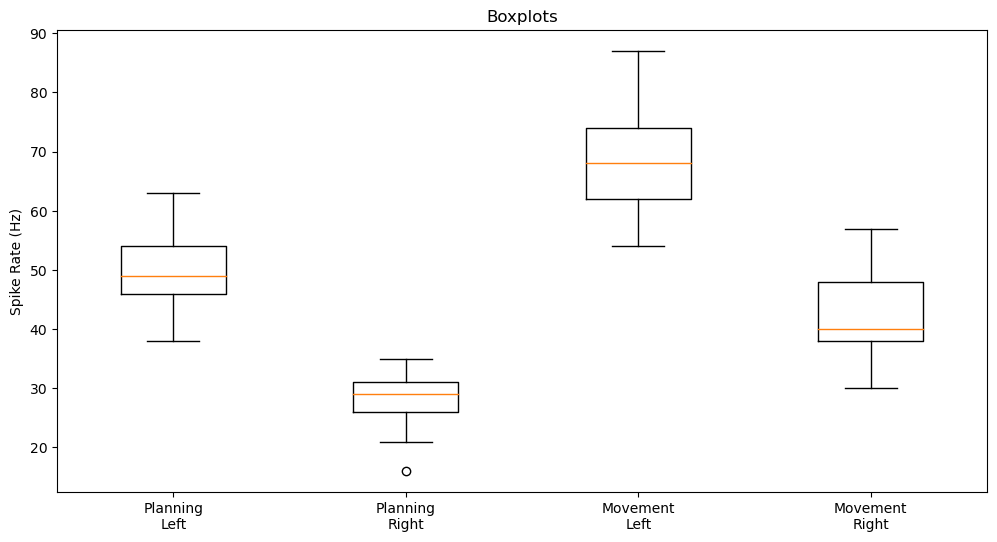

In [38]:
# Q7.4 CODE
PlanL = sum(train_l[:,:N//2], axis = 1)   
PlanR = sum(train_r[:,:N//2], axis = 1)   
MoveL = sum(train_l[:,N//2:], axis = 1)   
MoveR = sum(train_r[:,N//2:], axis = 1)   

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.boxplot([PlanL, PlanR, MoveL, MoveR], sym = 'o', labels = ['Planning\nLeft', 'Planning\nRight', 'Movement\nLeft', 'Movement\nRight'])
ax.set_title('Boxplots')
ax.set_ylabel('Spike Rate (Hz)')
plt.show()

<div class="alert alert-success">
<span style="color:black">

<!-- \begin{tcolorbox}[colback=green!5] -->
**A7.1 conclusion** 

Upon visual inspection of the dot-raster plots representing left and right directional movements, it's apparent that the spike density tends to be higher for movements towards the left compared to the right direction. Additionally, analyzing each plot individually reveals a consistent pattern: spike density is generally lower during the planning phase ($t<0$) and higher during the movement phase ($t>0$) of the trial, irrespective of the direction. While it's challenging to make a clear, overarching firing pattern throughout the entire trial duration, there are noticeable regions exhibiting rhythmic activity. However, it's important to acknowledge my, yet, limited expertise in neurophysiology...

<!-- \end{tcolorbox} -->
    
</span>

<div class="alert alert-success">
<span style="color:black">

<!-- \begin{tcolorbox}[colback=green!5] -->
**A7.2 conclusion** 
    
The choice of bin size can significantly influence the interpretation of PSTH results. Initially, using very small bin widths suggested a higher firing rate during both planning and movement phases compared to larger bin sizes. This discrepancy arose because the 1 ms bin size obscured bins with low PSTH values, which were 'overshadowed' by neighboring bins with higher PSTH values. Subsequent analysis with a 10 ms bin size provided a more accurate representation, revealing an average firing rate of 35 spikes/s during planning and 55 spikes/s during movement. Visually, (and maybe personally) in this case, a bin size of 10 ms provides a clearer distinction between the spiking rate int the planning and movement phase of the trail: the mean spike rate in the movement phase appears to be higher.

Selecting an appropriate bin size depends on the dataset and research objectives. Larger bin sizes may be preferred for datasets with lower spike rates or when observing broad trends over time. Conversely, smaller bin sizes are more suitable for datasets with high spike rates or when examining fine-scale temporal dynamics. However, caution should be exercised when choosing bin sizes, and results obtained with different bin sizes should (can) be compared to ensure reliability and robustness.
    
<!-- \end{tcolorbox} -->
    
</span>

<div class="alert alert-success">
<span style="color:black">

<!-- \begin{tcolorbox}[colback=green!5] -->
**A7.3 conclusion** 
    
As provided in the code above, a spiking rate of 38.96 spikes/s and 54.96 spikes/s are found for the planning and movement phase respectively. This result is similar to the estimation of the average firing rates, obtained from the histogram with 10 ms bin size.

By breaking down the rates into the left and right movement tasks, one can find a significant difference of 35.25 spikes/s versus 58.66 spikes/s for the right and left spiking rates respectively. One can conclude that spiking rates for planning and movement in left trials are higher than the rates for right trials.

<!-- \end{tcolorbox} -->
    
</span>

<div class="alert alert-success">
<span style="color:black">

<!-- \begin{tcolorbox}[colback=green!5] -->
**A7.4 conclusion** 
    
The S.I. unit for spikes/second is Hertz (Hz). From the boxplots above, one concludes that the firing rate is significantly higher in left trials and in the movement phase of each trial.

The firing rate is measured in Hertz (Hz): spikes per second. Analysis of the boxplots reveals significant differences in firing rates between left and right trials, as well as between the planning and movement phases of each trial. Specifically, the firing rate is notably higher during left trials compared to right trials, indicating a directional preference in neuronal activity. Additionally, within each trial, the firing rate increases during the movement phase compared to the planning phase. These findings highlight the influence of both direction and task on the firing activity of the subthalamic nucleus neurons.

<!-- \end{tcolorbox} -->
    
</span>

#### A8: Rhythmic structure  <a id="A8"></a>
* [Go back to Q8](#Q8)  

In [39]:
# Q8.1:use the following variables:
#plan_train
#move_train
#plan_average_ISI_hist  ##the average ISI histogram accross all trials for the planning activity, bins of 1ms
#move_average_ISI_hist  ##the average ISI histogram accross all trials for the moving activity, bins of 1 ms

# Q8.2:use the following variables:
#average_ACF_plan
#average_ACF_move

# Note for Q8.2:
# The 'full' correlation function repeats equal values twice, 
# Because going back in time is the same ACF value as going further in time. 
# Start your correlate array halfway of the values returned by np.correlate('full').

# Note for Q8.3:
# Power spectral density (psd)
# Below you find the package input needs.
# nitime.algorithms.spectral.multi_taper_psd(s, Fs=6.283185307179586, NW=None, BW=None, adaptive=False, jackknife=True, low_bias=True, sides='default', NFFT=None)
# Fs is the sampling rate per second, here 1000
# s is sample, so the plan or move train
# NW stands for the time - bandwidth. This gives 2*NW-1 (7)tapers
# to have a better understanding of the multitaper method, you can watch the following video:
# https://www.youtube.com/watch?v=OBwnmiVT9TE

# Try to create the mt_specpb function with the help of:
# https://mark-kramer.github.io/Case-Studies-Python/10.html

# Note for  Q8.4:
# The plt.contour function needs the following input.
# plt.contourf([X, Y,] Z, [levels], **kwargs) #Z is optional



def ACFloop():
    # Initialize ACF arrays
    average_ACF_plan = zeros((50, 1999))
    average_ACF_move = zeros((50, 1999))

    # Loop over every trial k
    for k in range(50):
        plan = train[k, planning_period_indices]
        move = train[k, movement_period_indices]

        # Compute ACF
        corr1 = correlate(plan - np.mean(plan), plan - np.mean(plan), 'full')
        average_ACF_plan[k] = corr1 / np.linalg.norm(plan - np.mean(plan))**2
        
        corr2 = correlate(move - np.mean(move), move - np.mean(move), 'full')
        average_ACF_move[k] = corr2 / np.linalg.norm(move - np.mean(move))**2

    return average_ACF_plan, average_ACF_move

In [40]:
# Q8.1 CODE
plan_train = train[:, planning_period_indices]
move_train = train[:, movement_period_indices]

plan_spike_times = np.where(plan_train >= 1)[1] 
move_spike_times = np.where(move_train >= 1)[1] 

ISI_plan = np.diff(plan_spike_times)
ISI_plan = ISI_plan[np.where(ISI_plan >= 0)]
ISI_move = np.diff(move_spike_times)
ISI_move = ISI_move[np.where(ISI_move >= 0)]
max_ISI = np.max([np.percentile(ISI_plan, 97.5), np.percentile(ISI_move, 97.5)])
#print(max_ISI)

# get the histograms
bins_1ms = np.arange(0, max_ISI + 1, 1)
plan_average_ISI_hist = np.histogram(ISI_plan, bins = bins_1ms)[0] / 50  # calucalate the histogram and average over trails (50)
move_average_ISI_hist = np.histogram(ISI_move, bins = bins_1ms)[0] / 50  # calucalate the histogram and average over trails (50)
plan_average_ISI_hist_density = np.histogram(ISI_plan, bins = bins_1ms, density = True)[0] # get the density
move_average_ISI_hist_density = np.histogram(ISI_move, bins = bins_1ms, density = True)[0] # get the density

# get the standard deviations
plan_std = np.std(np.array([np.histogram(row, bins = bins_1ms)[0] for row in ISI_plan]), axis = 0)
move_std = np.std(np.array([np.histogram(row, bins = bins_1ms)[0] for row in ISI_move]), axis = 0)

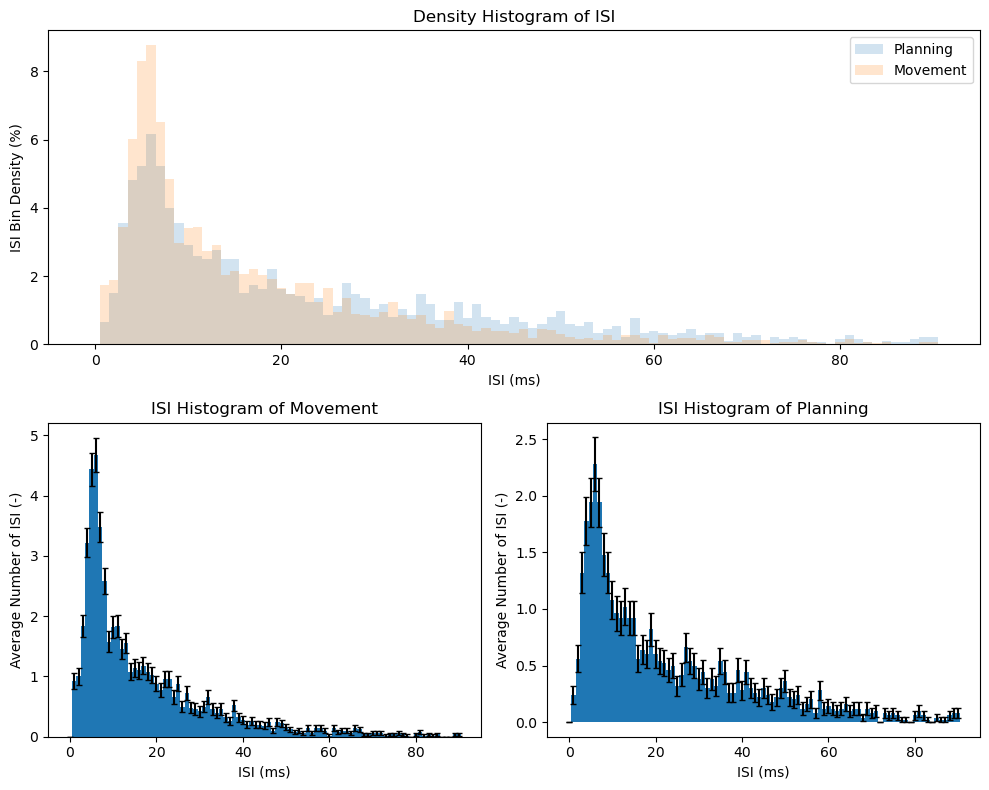

In [41]:
fig = plt.figure(figsize = (10, 4*2))

# add axes to the figure
ax11 = fig.add_subplot(2, 1, 1)
ax12 = fig.add_subplot(2, 2, 3)
ax13 = fig.add_subplot(2, 2, 4)

# Denisty Plot #
ax11.set_title('Density Histogram of ISI')

ax11.bar(bins_1ms[:-1], plan_average_ISI_hist_density * 100, width = 1, alpha = 0.2, label = 'Planning')
ax11.bar(bins_1ms[:-1], move_average_ISI_hist_density * 100, width = 1, alpha = 0.2, label = 'Movement')

ax11.set_xlabel('ISI (ms)')
ax11.set_ylabel('ISI Bin Density (%)')

ax11.legend()

# Movement histogram
ax12.set_title('ISI Histogram of Movement')

ax12.bar(bins_1ms[:-1], move_average_ISI_hist, width = 1, yerr = move_std, capsize = 2)

ax12.set_xlabel('ISI (ms)')
ax12.set_ylabel('Average Number of ISI (-)')


# Planning histogram
ax13.set_title('ISI Histogram of Planning')

ax13.bar(bins_1ms[:-1], plan_average_ISI_hist, width = 1, yerr = plan_std, capsize = 2)

ax13.set_xlabel('ISI (ms)')
ax13.set_ylabel('Average Number of ISI (-)')


plt.tight_layout()
plt.show()

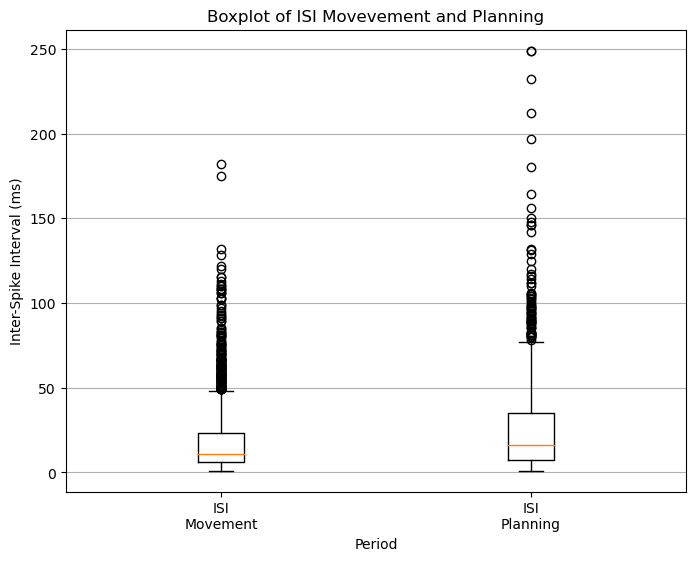

In [42]:
# Create a list of the ISI data for plotting
data = [ISI_move, ISI_plan]

# Create the boxplot
plt.figure(figsize=(8, 6))
plt.boxplot(data, labels=['ISI\nMovement', 'ISI\nPlanning'])
plt.title('Boxplot of ISI Movevement and Planning')
plt.ylabel('Inter-Spike Interval (ms)')
plt.xlabel('Period')
plt.grid(axis = 'y')  
plt.show()



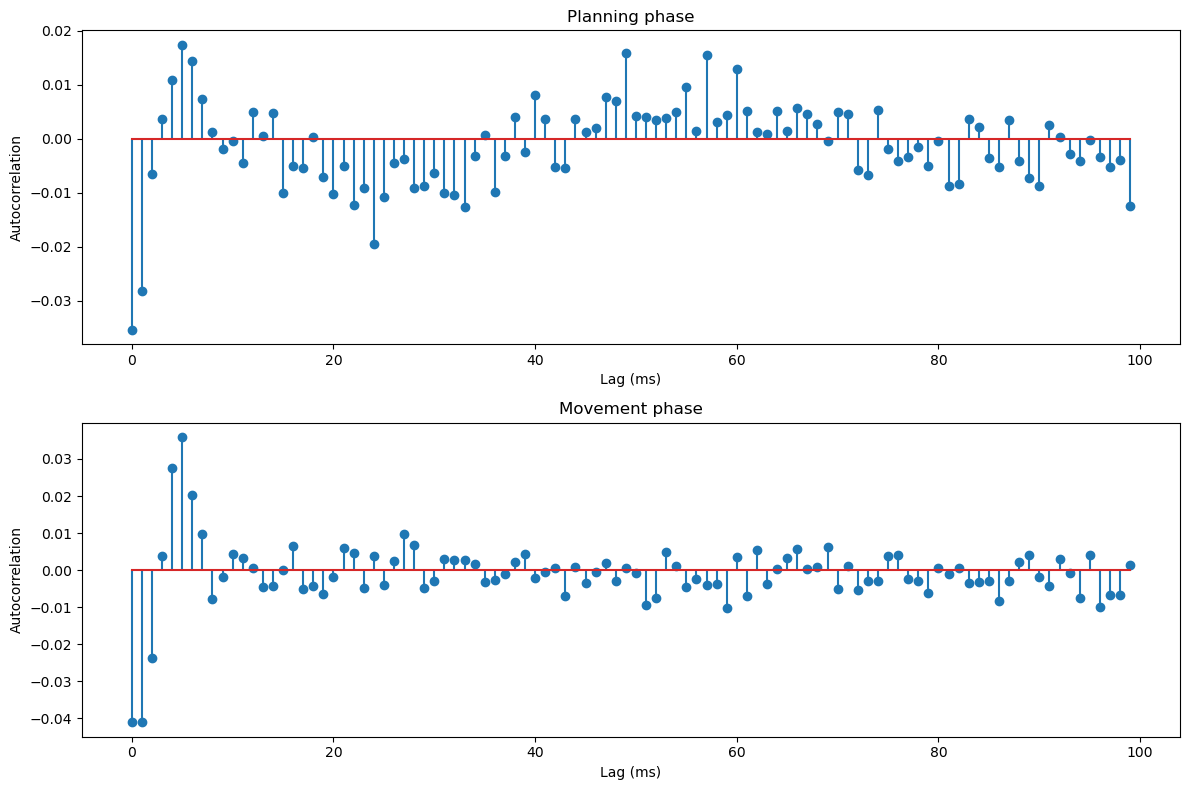

In [43]:
# Q8.2 CODE
average_ACF_plan, average_ACF_move = ACFloop()

# Construct ACF plot
plt.figure(figsize = (12, 4*2))

plt.subplot(211)
plt.stem(mean(average_ACF_plan[:,1000:1100], axis = 0))
plt.xlabel('Lag (ms)')
plt.ylabel('Autocorrelation')
plt.title('Planning phase')

plt.subplot(212)
plt.stem(mean(average_ACF_move[:,1000:1100], axis = 0))
plt.xlabel('Lag (ms)')
plt.ylabel('Autocorrelation')
plt.title('Movement phase')

plt.tight_layout()
plt.show()

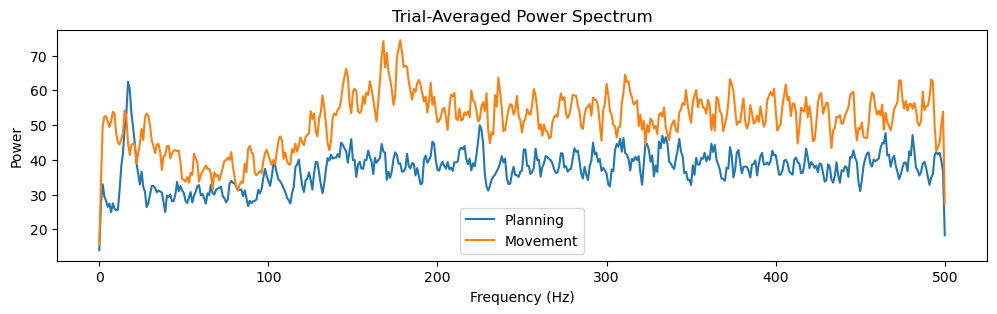

In [44]:
# Q8.3 CODE
Fs = 1e3

# get the spectra
f, S_plan, var = multi_taper_psd(plan_train, Fs = 1 / 1e-3, BW = 4)
f, S_move, var = multi_taper_psd(move_train, Fs = 1 / 1e-3, BW = 4)

# average over the trials
S_plan = np.mean(S_plan, axis = 0) * Fs ** 2 / 2
S_move = np.mean(S_move, axis = 0) * Fs ** 2 / 2

plt.figure()
plt.plot(f, S_plan, label = "Planning")
plt.plot(f, S_move, label = "Movement")

plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.title('Trial-Averaged Power Spectrum')
plt.legend()
plt.show()

In [45]:
def mt_specpb(data, Fs = 1000, NW = 4, trial_ave = True):
    
    # Compute & scale tapers
    tapers, _ = dpss_windows(data.shape[-1], NW, 2*NW-1)
    tapers *= sqrt(Fs)
    
    dataT = [[trial * t for t in tapers] for trial in data]
    T = rfft(tapers)
    J = rfft(dataT)

    # Compute spectrum
    J -= [T * trial.mean() for trial in data]
    J *= J.conj()
    S = J.mean(1).real
    f = rfftfreq(data.shape[-1], 1 / Fs)
    if trial_ave: S = S.mean(0)
    
    return f, S

f_plan_manual, S_plan_manual = mt_specpb(plan_train)
f_move_manual, S_move_manual = mt_specpb(move_train)

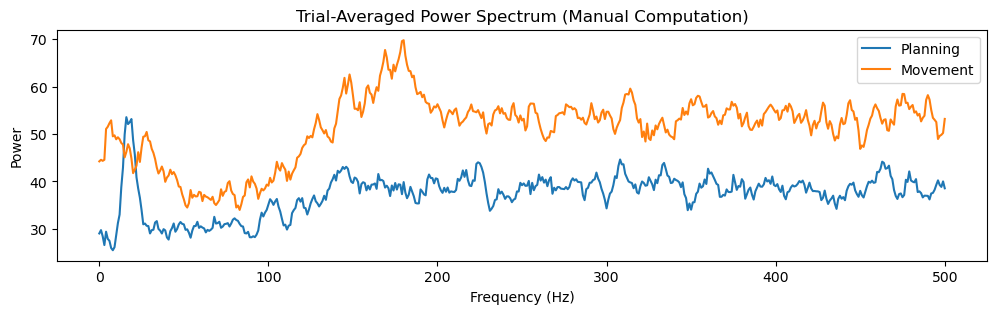

In [46]:
plt.figure()
plt.plot(f_plan_manual, S_plan_manual, label = "Planning")
plt.plot(f_move_manual, S_move_manual, label = "Movement")

plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.title('Trial-Averaged Power Spectrum (Manual Computation)')
plt.legend()
plt.show()

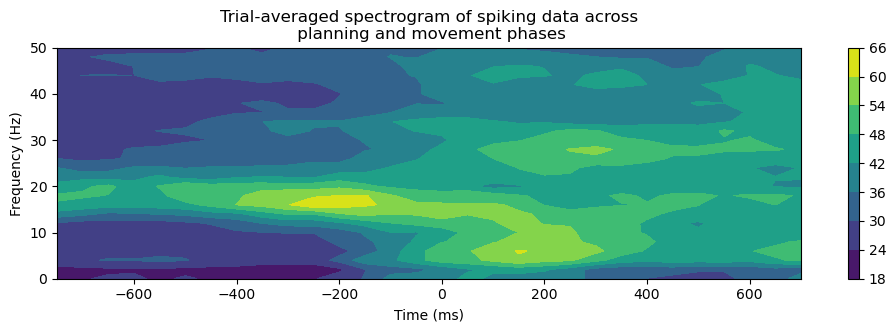

In [47]:
# Q8.4 CODE
window, step = .5, .05
fpass = [0, 50]
Fs = 1000

window, step = [int(Fs * x) for x in [window, step]]
starts = range(0, train.shape[-1] - window, step)
# Get frequencies
f = mt_specpb(train[:, range(window)], NW=2)[0]
findx = (f >= fpass[0]) & (f <= fpass[1])
f = f[findx]
# Compute and center the spectrum on each 500 ms window.
spectrogram = [mt_specpb(train[:, range(s, s + window)], NW=2)[1][findx] for s in starts]
T = t[starts] + window / 2   

# Construct plot
plt.contourf(T, f, array(spectrogram).T)
plt.xlabel('Time (ms)')
plt.ylabel('Frequency (Hz)')
plt.title('Trial-averaged spectrogram of spiking data across\n planning and movement phases')
cbar = plt.colorbar()
plt.show()

<div class="alert alert-success">
<span style="color:black">

**A8.1 conclusion** 

Analysis of the ISI distributions during the movement period reveals notable trends. Firstly, there is a significant increase in the total number of ISIs compared to the planning period, aligning with the previously identified higher firing rate during movement. Moreover, a prominent peak around 6 ms suggests a more pronounced tendency for burst firing during movement. While there are some variations in the tail structure of the ISI distribution for longer ISIs (> 20 ms), their correlation with rhythmic spiking patterns remains challenging to ascertain definitively. Furthermore, you can see that the variation of ISIs in the planning phase is higher (boxplots).
    
</span>

<div class="alert alert-success">
<span style="color:black">

<!-- \begin{tcolorbox}[colback=green!5] -->
**A8.2 conclusion** 
        
The coefficients of the autocorrelation function (ACF) during the planning phase generally exhibit higher absolute values, suggesting the presence of a discernible spiking pattern during this period. In contrast, the autocorrelation coefficients are notably lower during the movement phase, indicating a reduced or potentially absent rhythmic spiking pattern.

<!-- \end{tcolorbox} -->
    
</span>

<div class="alert alert-success">
<span style="color:black">

<!-- \begin{tcolorbox}[colback=green!5] -->
**A8.3 conclusion** 
    
The spectral density analysis reveals distinct features in the spiking activity of the planning and movement periods. During the planning phase, a prominent peak around 10-20 Hz is observed, indicative of rhythmic spiking activity. Additionally, the spectral density ocsillates around 35 Hz at higher frequencies. In contrast, the movement phase exhibits an overall higher spectral density, with a parabolic-like function spanning 0-200 Hz and a maximum power around 200 Hz. Notably, there is no distinct frequency peak present in the movement phase, indicating a more variable firing pattern compared to the planning phase. The absence of a peak at around 10-20 Hz during the movement phase suggests that the rythmic spiking during planning, will be attenuated during movement. 

<!-- \end{tcolorbox} -->
    
</span>

<div class="alert alert-success">
<span style="color:black">

<!-- \begin{tcolorbox}[colback=green!5] -->
**A8.4 conclusion** 
    
The spectral analysis of the planning and movement periods reveals distinct frequency components and dynamic changes in spectral behavior. During the planning phase, frequency components are most dominant around 10-20 Hz, indicative of rhythmic spiking activity. In contrast, the movement phase shows an attenuation of this frequency component and an increase in power at higher frequencies. This sudden change in spectral behavior during the transition from planning to movement supports the hypothesis of stationary data. 

<!-- \end{tcolorbox} -->
    
</span>